ReadMe(DataProcess):
1. Download tech stock data from Jan 4, 2020-Dec 31, 2023.
Output: one dataframe per day
Column Names: returns | open | close | high | low | volume | vwap | cap | -1Hour | -1H_Return
    - -1Hour is the last hour open price before the market closes

2. Self-defined functions to add in additional columns
   - adv{d} = average daily dollar volume for the past d days.(This is the main constraint to computing speed for many alphas)

  
ReadMe(Formulaic Alpha)
1. Delay 0 alphas have position one hour before close. Position Cleared at the end of the day.
2. Delay n, n>0 have position at the beginning of next day. If position contains same stock, only make adjustment to the change of position. The difference between previous day's close and today's open is neglected.
3. Only alpha that uses previous day's close price uses the adjusted close price.

Note: 
- whenever two ranks are divided. Rank is adjusted to range between 1 and 2 such that properly comparison can be made
- whenever signedpower is used between two computed variables, base is adjsuted to range between 0 and 1 so that the smallest becomes the largest when the exponent is zero. If the exponent is a rank, it's also adjusted to range between 0 and 1.
- whenever the alpha is all negative / positive, rank is applied.
- an additional functionality is implemented as rtrn_neg to adjust the proportion of alphas to be accepted instead of using uniform weighting through rank.
- rank weights slightly more on large cap firms. 


ReadMe(Data Aggregation)
1. Data Aggregation is done separately between delay-0 and delay-n>0.
3. Assume total principle starting to be $100,000.
4. We compute the average principle over time and use that as the base for daily volume.
5. Everyday's position is calculated according to the proportion of the positive alphas.
6. The daily trading volume and shares are calculated such that any adjustment made at the end of day -1 is counted towards today for delay n>0.

Note:
- we create two lists of alpha because alpha 63,71,76,96,98 are slow to compute and alpha 97 is extremely slow to compute due to the number of loops applied in the construction
- PandL: element wise multi of principles and returns

Procedures:
1. The return matrix is computed by taking each column of the position matrix for each alpha and computes its return.
    - The Position matrix calculates the position for every day and summarize it into one single sheet. For delay-n>0, the position is   set for the next day.
    - Rtrn_t0 and rtrn_tn are set such that one takes the -1hour return and the other the daily return.
2. principle_t computes the rolling principles for each alpha, if alpha hasn't been applicable at the time, assume no trade is made. principles compute the average principle for each alpha.
3. Daily - volume and shares traded are computed as described. A daily volume larger than 1 implies the value of more than the entire portfolio is sold everyday.
4. The correlation matrix and the std of the returns are also computed.
5. Stats summarize daily PandL, average Principles, std of returns, daily trading volume, daily shares traded, and daily returns.
The following are computed:

Annualized Sharpe ratio: sqrt(252) * daily avg of PandL / (average Principles * std of returns)
Turnover: daily avg of trading volume / average Principles
Holding Period:  1/Turnover
cent_per_share: 100% * daily avg PandL / avg daily shares traded
avg_rtrn_1(more accurate): 100% * daily avg return 
avg_rtrn_2: 100% * daily avg PandL / average Principles
std_R_1000: std of the return * 1000


ReadMe(Modeling)
Note: Run create_database when fetching data for the first time
1. Compute Return v. Volatility & Turnover


Results:
All data points:
1. The average (median) pair- wise correlation of these alphas is high, 83.93%
2. But the anualized return ranges between -120% and 21%.
3. The average holding period has an interquatile range from 0.8 to 2.2 days.
4. The returns have moderate dependence on both the volatility and the turnover using all the alphas.

Delay-n data points:
1. The same analysis is done to delay-n alphas only.
2. The returns have little dependence on both the volatility and the turnover.

EDA:
1. A quick analysis of the modeling data sets show that the delay-0 strategies have significantly lower sharpe ratio and returns.
2. Alpha-24, alpha-70 have the highest returns and also very high sharpe ratios. Alpha-24 is a mean-reversion strategy that separates more volatile stocks from less volatile ones using the close price. Alpha-70 is a mean-reversion strategy that selects stocks that have high correlation between close price and volume in the past 2 weeks.
3. The principle values of the 3 alphas with the highest returns, highest sharpe ratio, and lowest returns are graphed.
4. In the future, klustering analysis might reveal more detailed performance insights based on different market conditions over time and strategies.

In [767]:
import yfinance as yf
import pandas as pd
import os
import datetime as dt
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [139]:
import warnings
warnings.filterwarnings("ignore", category=np.ComplexWarning)

In [7]:
# tech industry portfolio:
pf_info = pd.read_csv(os.path.join(os.getcwd(), "Data/IYW_holdings.csv"),skiprows = 9)

In [2256]:
tech_port = pf_info.filter(items = ['Ticker', 'Sector']).drop(range(141,146)).drop(110)
start_date = "2022-08-01"
end_date = "2024-07-15"

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

In [2233]:
# run this at the beginning
# db = create_database(tech_port, start_date, end_date)

In [2257]:
db2 = read_database(start_date, end_date)

In [2258]:
alpha_0 = {'Alpha_42', 'Alpha_48', 'Alpha_53', 'Alpha_54'}
alpha_neg = {'Alpha_x'}
alpha_set = {f'Alpha_{i}' for i in range(1, 102)}
slow_alphas = {'Alpha_63', 'Alpha_71', 'Alpha_76', 'Alpha_96', 'Alpha_98'}
very_slow_alphas = {'Alpha_97'}
exclude_very_slow = alpha_set - very_slow_alphas
exclude_slow = exclude_very_slow - slow_alphas
alpha_n = exclude_slow - alpha_0

In [2279]:
r = rtrn(db2, exclude_slow, alpha_neg, alpha_n, tech_port['Sector'])

p = principles_t(r, 100000)

pl = PandL_t(p, r)
Principle = principles(p)

In [2281]:
dv = daily_vol_t(Principle, db2, exclude_slow, alpha_neg, alpha_n, r, tech_port['Sector'])

st = share_traded_t(p, db2, exclude_slow, alpha_neg, alpha_n, 100000, tech_port['Sector'])

cm, std_devs, pair_corr = corr_vol(r)

corr_sum = pair_corr.describe().T.drop(['count'],axis = 1)

model_data = stats(pl, Principle, std_devs, dv, st, r)
model_data = model_data.astype(float)
summary_0 = model_data.describe().T.drop(['count'],axis = 1)

In [2282]:
summary = pd.concat([summary_0,corr_sum])
summary

,mean,std,min,25%,50%,75%,max
Sharpe,0.351257,4.800253,-40.514808,0.966830,1.203854,1.339581,2.042153
Turnover,0.792080,0.475030,0.005002,0.464244,0.659516,1.167476,1.995424
avg_holding_period,5.274034,22.588134,0.501147,0.856798,1.516263,2.154923,199.908233
cent_per_share,37.897589,235.379236,-24.062246,5.254135,7.883754,12.256755,2281.959385
avg_rtrn_1,0.053702,0.193320,-1.211950,0.074146,0.090535,0.104059,0.209172
avg_rtrn_2,0.056973,0.195875,-1.343352,0.080747,0.095670,0.109186,0.208685
std_R_1000,12.699790,1.930158,5.263522,11.937813,12.859106,13.515332,18.751840
Corr%,83.933967,22.404088,-21.043291,85.657829,92.161687,94.942993,99.920639


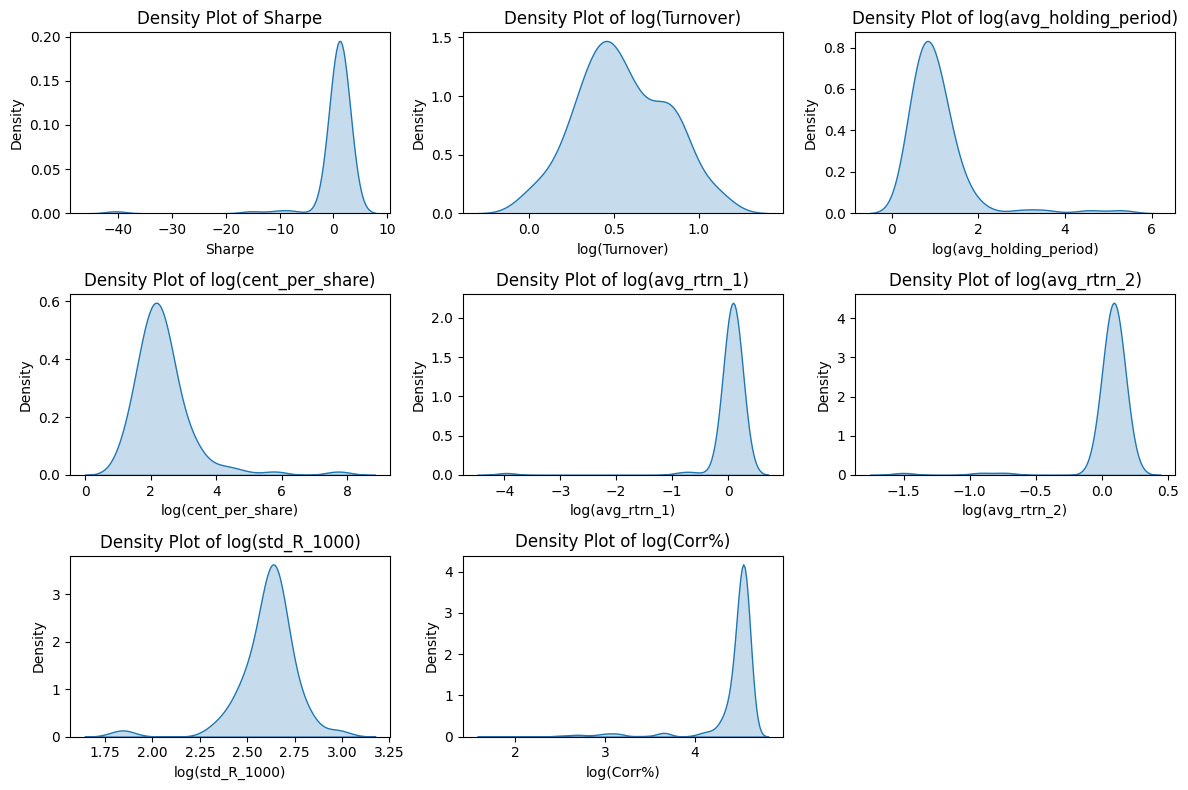

In [2283]:
features = ['Sharpe', 'Turnover', 'avg_holding_period', 'cent_per_share', 'avg_rtrn_1', 'avg_rtrn_2', 'std_R_1000', 'Corr%']
log_transform_features = ['Turnover', 'avg_holding_period', 'cent_per_share', 'avg_rtrn_1', 'avg_rtrn_2', 'std_R_1000', 'Corr%']
x_label = ['log(Turnover)', 'log(avg_holding_period)', 'log(cent_per_share)', 'log(avg_rtrn_1)', 'log(avg_rtrn_2)', 'log(std_R_1000)','log(Corr%)']
plot(model_data, pair_corr, features, log_transform_features, x_label)

In [2288]:
model_data.sort_values(by = ['Sharpe'], axis = 0).head(5)

,Sharpe,Turnover,avg_holding_period,cent_per_share,avg_rtrn_1,avg_rtrn_2,std_R_1000,ln_avg_rtrn1,ln_avg_rtrn2,ln_std,ln_Turnover
Alpha_42,-40.514808,1.987880,0.503048,-16.692031,-1.211950,-1.343352,5.263522,-0.012194,-0.013525,0.005250,1.094564
Alpha_54,-15.301786,1.995424,0.501147,-12.367836,-0.457570,-0.516622,5.359587,-0.004586,-0.005180,0.005345,1.097086
Alpha_53,-10.364219,1.994331,0.501421,-14.575940,-0.566850,-0.601438,9.212019,-0.005685,-0.006033,0.009170,1.096721
Alpha_48,-7.748963,1.990191,0.502464,-24.062246,-0.980940,-0.776891,15.915380,-0.009858,-0.007799,0.015790,1.095337
Alpha_57,0.302249,1.258212,0.794778,2.108284,0.016897,0.025029,13.145509,0.000169,0.000250,0.013060,0.814574


In [2287]:
model_data.sort_values(by = ['avg_rtrn_1'], axis = 0).head(5)

,Sharpe,Turnover,avg_holding_period,cent_per_share,avg_rtrn_1,avg_rtrn_2,std_R_1000,ln_avg_rtrn1,ln_avg_rtrn2,ln_std,ln_Turnover
Alpha_42,-40.514808,1.987880,0.503048,-16.692031,-1.211950,-1.343352,5.263522,-0.012194,-0.013525,0.005250,1.094564
Alpha_48,-7.748963,1.990191,0.502464,-24.062246,-0.980940,-0.776891,15.915380,-0.009858,-0.007799,0.015790,1.095337
Alpha_53,-10.364219,1.994331,0.501421,-14.575940,-0.566850,-0.601438,9.212019,-0.005685,-0.006033,0.009170,1.096721
Alpha_54,-15.301786,1.995424,0.501147,-12.367836,-0.457570,-0.516622,5.359587,-0.004586,-0.005180,0.005345,1.097086
Alpha_57,0.302249,1.258212,0.794778,2.108284,0.016897,0.025029,13.145509,0.000169,0.000250,0.013060,0.814574


In [2290]:
model_data.sort_values(by = ['avg_rtrn_1'], axis = 0, ascending = False).head(5)

,Sharpe,Turnover,avg_holding_period,cent_per_share,avg_rtrn_1,avg_rtrn_2,std_R_1000,ln_avg_rtrn1,ln_avg_rtrn2,ln_std,ln_Turnover
Alpha_24,1.799187,0.993739,1.006300,27.230746,0.209172,0.208685,18.412572,0.002090,0.002085,0.018245,0.690012
Alpha_70,1.787958,1.005280,0.994747,7.883754,0.136458,0.129185,11.469754,0.001364,0.001291,0.011404,0.695784
Alpha_7,1.591980,1.187400,0.842176,4.745256,0.133697,0.127926,12.756191,0.001336,0.001278,0.012676,0.782714
Alpha_12,1.423715,1.432763,0.697952,11.773526,0.133665,0.139396,15.542785,0.001336,0.001393,0.015423,0.889028
Alpha_87,1.552980,0.930244,1.074987,7.044873,0.132172,0.121147,12.383649,0.001321,0.001211,0.012308,0.657646


In [2291]:
model_data.sort_values(by = ['Sharpe'], axis = 0, ascending = False).head(5)

,Sharpe,Turnover,avg_holding_period,cent_per_share,avg_rtrn_1,avg_rtrn_2,std_R_1000,ln_avg_rtrn1,ln_avg_rtrn2,ln_std,ln_Turnover
Alpha_88,2.042153,0.507383,1.970899,13.728635,0.122871,0.119049,9.254151,0.001228,0.001190,0.009212,0.410375
Alpha_37,1.888667,1.013316,0.986859,8.672914,0.131299,0.127347,10.703676,0.001312,0.001273,0.010647,0.699783
Alpha_24,1.799187,0.993739,1.006300,27.230746,0.209172,0.208685,18.412572,0.002090,0.002085,0.018245,0.690012
Alpha_70,1.787958,1.005280,0.994747,7.883754,0.136458,0.129185,11.469754,0.001364,0.001291,0.011404,0.695784
Alpha_36,1.762472,0.753275,1.327537,9.364700,0.119595,0.117031,10.540932,0.001195,0.001170,0.010486,0.561485


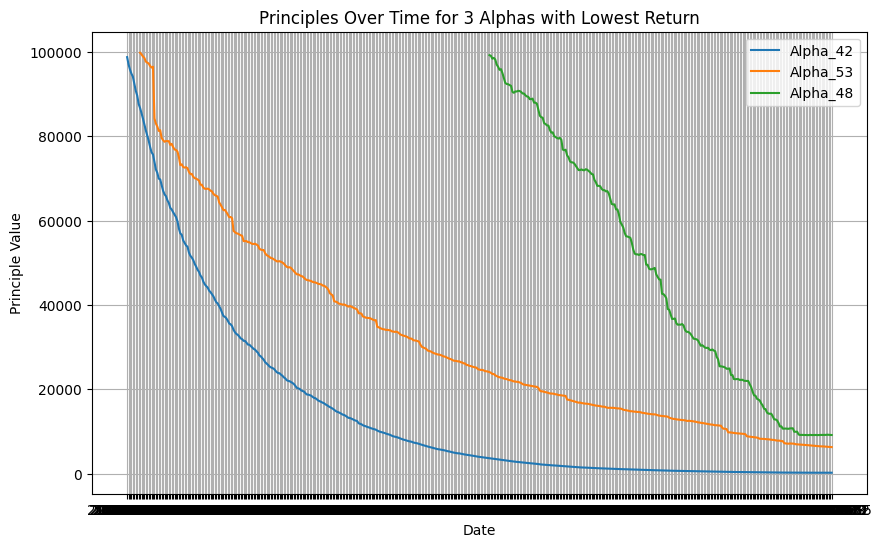

In [2298]:
plotEda({'Alpha_42', 'Alpha_48', 'Alpha_53'}, ' Lowest Return', p)

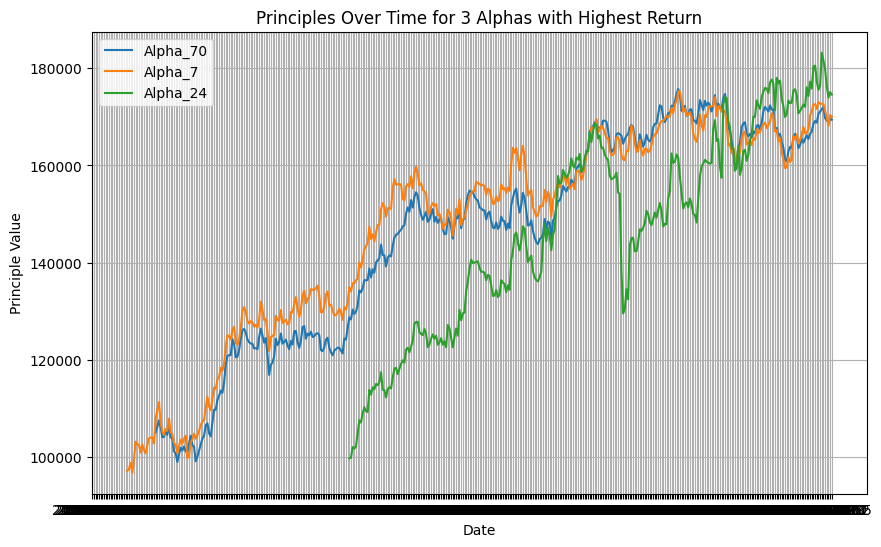

In [2299]:
plotEda({'Alpha_24', 'Alpha_70', 'Alpha_7'}, ' Highest Return', p)

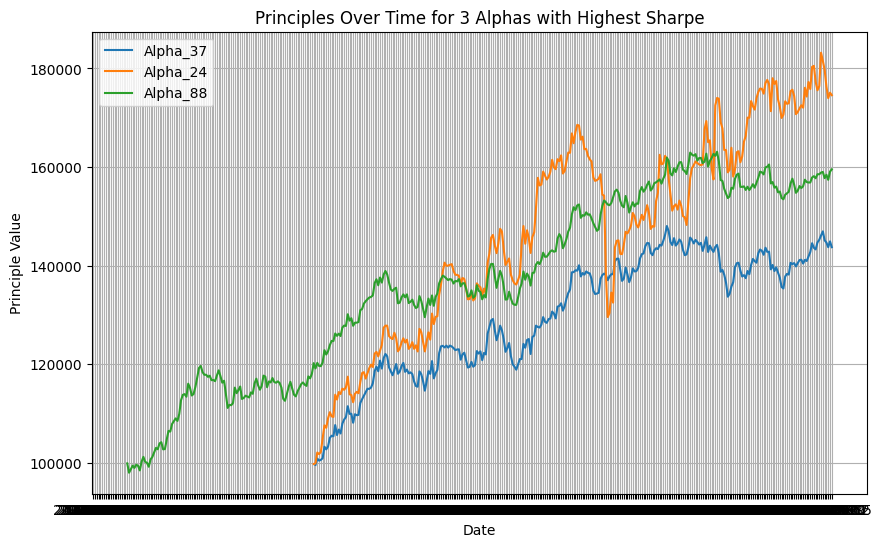

In [2300]:
plotEda({'Alpha_88', 'Alpha_37', 'Alpha_24'}, ' Highest Sharpe', p)

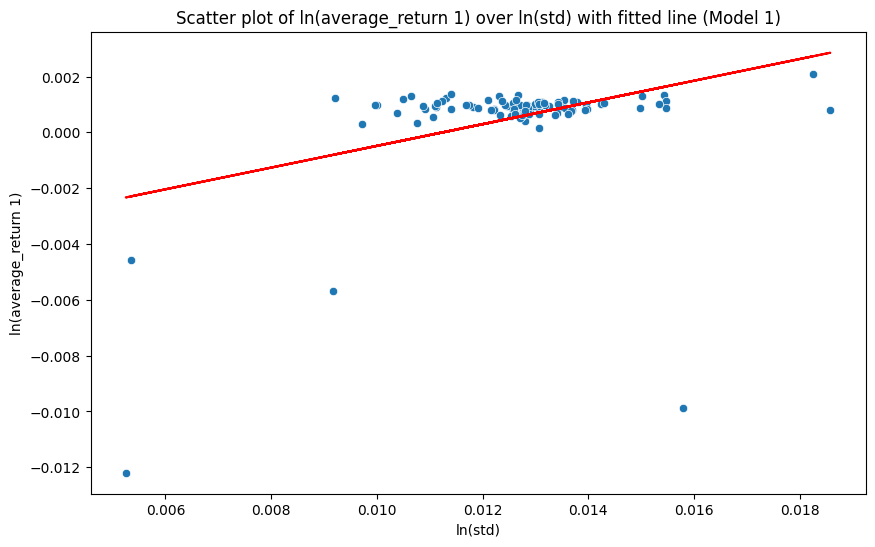

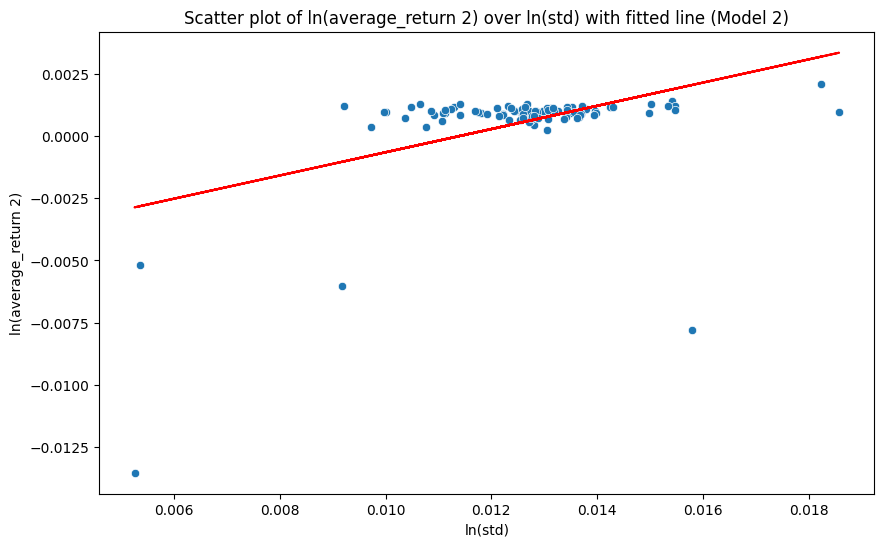

,Model 1,Model 2,Model 3,Model 4
Intercept,-0.004374,-0.005312,-3.142809e-03,-4.064921e-03
Slope (ln_std),0.389057,0.465999,4.397046e-01,5.173100e-01
Slope (ln_Turnover),NaN,NaN,-3.402098e-03,-3.446619e-03
R-squared,0.146004,0.203932,3.505198e-01,4.082936e-01
F-statistic,15.899745,23.824231,2.482587e+01,3.174125e+01
P-value (F-statistic),0.000133,0.000004,2.387983e-09,3.287680e-11


In [2284]:
model = linearModel(model_data)
model

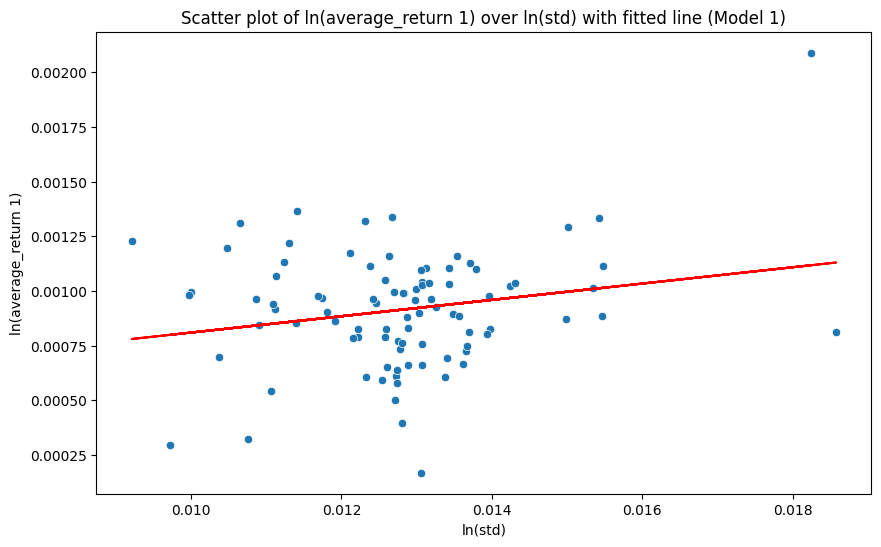

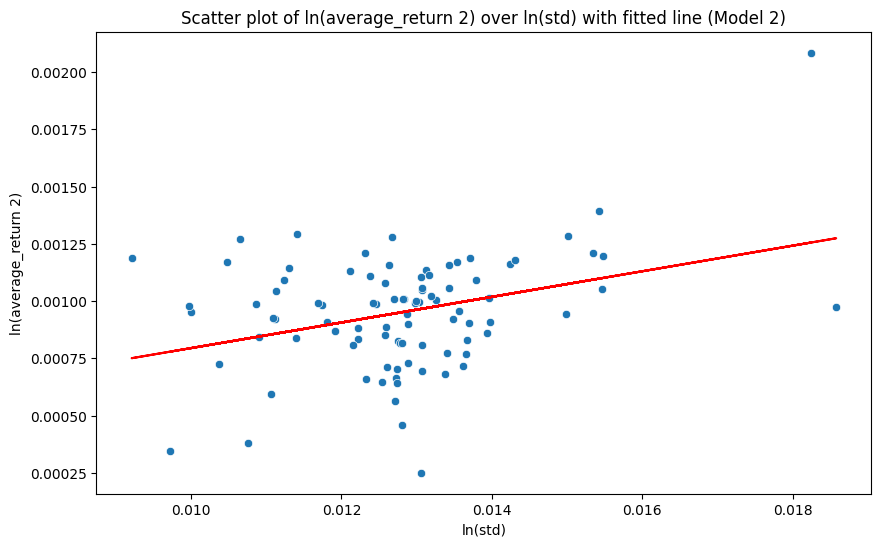

,Model 1,Model 2,Model 3,Model 4
Intercept,0.000436,0.000235,0.000422,0.000225
Slope (ln_std),0.037345,0.055938,0.040396,0.058119
Slope (ln_Turnover),NaN,NaN,-0.000047,-0.000034
R-squared,0.045397,0.118332,0.046849,0.119194
F-statistic,4.232443,11.944998,2.162651,5.954256
P-value (F-statistic),0.042585,0.000842,0.121095,0.003756


In [2309]:
model_data_delay_n = model_data.drop(index=['Alpha_42', 'Alpha_48', 'Alpha_53', 'Alpha_54'], axis = 0)
model_delay_n = linearModel(model_data_delay_n)
model_delay_n

Modeling





In [2081]:
def linearModel(model_data):
    # Prepare the data with log transformations
    model_data['ln_avg_rtrn1'] = np.log1p(model_data['avg_rtrn_1']/100)
    model_data['ln_avg_rtrn2'] = np.log1p(model_data['avg_rtrn_2']/100)
    model_data['ln_std'] = np.log1p(model_data['std_R_1000']/1000)
    model_data['ln_Turnover'] = np.log1p(model_data['Turnover'])

    # Model 1: ln(average_return1) ~ ln(std)
    X1 = sm.add_constant(model_data['ln_std'])
    y1 = model_data['ln_avg_rtrn1']
    model1 = sm.OLS(y1, X1).fit()
    
    # Model 2: ln(average_return2) ~ ln(std)
    y2 = model_data['ln_avg_rtrn2']
    model2 = sm.OLS(y2, X1).fit()
    
    # Model 3: ln(average_return1) ~ ln(std) + ln(Turnover)
    X2 = sm.add_constant(model_data[['ln_std', 'ln_Turnover']])
    model3 = sm.OLS(y1, X2).fit()
    
    # Model 4: ln(average_return2) ~ ln(std) + ln(Turnover)
    model4 = sm.OLS(y2, X2).fit()

    plotModel(model_data['ln_std'], y1, model1, 1, 1)
    plotModel(model_data['ln_std'], y2, model2, 2, 2)

    sum1 = summary_stats(model1, 1)
    sum2 = summary_stats(model2, 2)
    sum3 = summary_stats2(model3, 3)
    sum4 = summary_stats2(model4, 4)
    return pd.concat([sum1,sum2,sum3,sum4],axis = 1)

In [2082]:
def plotModel(X,Y,model, num, index):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X, y=Y)
    plt.plot(X, model.fittedvalues, color='red')
    plt.title('Scatter plot of ln(average_return ' + str(index) + ') over ln(std) with fitted line (Model ' + str(num) + ')')
    plt.xlabel('ln(std)')
    plt.ylabel('ln(average_return ' + str(index) + ')')
    plt.show()

In [2083]:
def summary_stats(model, num):
    summary = {
        'Model ' + str(num): {
            'Intercept': model.params['const'],
            'Slope (ln_std)': model.params['ln_std'],
            'Slope (ln_Turnover)': None,
            'R-squared': model.rsquared,
            'F-statistic': model.fvalue,
            'P-value (F-statistic)': model.f_pvalue
        }}
    return pd.DataFrame(summary)

In [2084]:
def summary_stats2(model, num):
    summary = {
        'Model ' + str(num): {
            'Intercept': model.params['const'],
            'Slope (ln_std)': model.params['ln_std'],
            'Slope (ln_Turnover)': model.params['ln_Turnover'],
            'R-squared': model.rsquared,
            'F-statistic': model.fvalue,
            'P-value (F-statistic)': model.f_pvalue
        }}
    return pd.DataFrame(summary)

Data Aggregation





In [2296]:
def plotEda(alpha_set, title, principles_df):
    # Transpose the DataFrame for plotting
    principles_df_t = principles_df.T
    
    # Plot the line plot for the principles over time for these top 3 alphas
    plt.figure(figsize=(10, 6))
    
    for alpha in alpha_set:
        plt.plot(principles_df_t.index, principles_df_t[alpha], label=alpha)
    
    plt.title(f'Principles Over Time for 3 Alphas with{title}')
    plt.xlabel('Date')
    plt.ylabel('Principle Value')
    plt.legend()
    plt.grid(True)
    plt.show()

In [2085]:
def plot(model_data, pair_corr, features, log_transform_features, x_label):
    # Plot density plots
    plt.figure(figsize=(12, 8))
    for i, feature in enumerate(features, 1):
        plt.subplot(3, 3, i)
        if feature == 'Corr%':
            sns.kdeplot(np.log1p(pair_corr[feature]), shade=True)
            plt.title(f'Density Plot of log({feature})')
            plt.xlabel(f'log({feature})')
        elif feature in log_transform_features:
            sns.kdeplot(np.log1p(model_data[feature]), shade=True)
            plt.title(f'Density Plot of log({feature})')
            plt.xlabel(f'log({feature})')
        else:
            sns.kdeplot(model_data[feature], shade=True)
            plt.title(f'Density Plot of {feature}')
            plt.xlabel(feature)
    plt.tight_layout()
    plt.show()

In [2086]:
def stats(PandL_df, Principles_ds, std_ds, dv_df, Quantity_df, rtrn_df):
    PandL = PandL_df.mean(axis = 1)
    V = Principles_ds * std_ds
    Sharpe = math.sqrt(252) * PandL / V
    
    dv = dv_df.mean(axis = 1)
    Turnover = dv / Principles_ds

    avg_holding_period = 1 / Turnover

    Quantity = Quantity_df.mean(axis = 1)
    cent_per_share = 100 * PandL / Quantity

    avg_rtrn_1 = rtrn_df.mean(axis = 1) * 100

    avg_rtrn_2 = PandL / Principles_ds * 100

    std_R_1000 = std_ds * 1000
    op = pd.concat([Sharpe, Turnover, avg_holding_period, cent_per_share, avg_rtrn_1, avg_rtrn_2, std_R_1000], axis = 1)
    op.columns = ['Sharpe', 'Turnover', 'avg_holding_period', 'cent_per_share', 'avg_rtrn_1', 'avg_rtrn_2', 'std_R_1000']

    return op
    

In [2087]:
def corr_vol(returns):
    cm = returns.T.corr()
    std_devs = returns.T.std()
    ucm = cm.where(np.triu(np.ones(cm.shape), k=1).astype(bool))
    pair_corr = ucm.stack().reset_index()
    pair_corr.columns = ['Row','Column','Corr%']
    pair_corr['Corr%']= pair_corr['Corr%'] *100
    return cm, std_devs, pair_corr

In [2088]:
def share_traded_t(principles, db, alphas, alpha_neg, alpha_n, initial, industry):
    all_quantity = []
    dates = db.keys()

    vwap_dict = {}
    for date_str in dates:
        vwap_dict[date_str] = db[date_str]['VWAP']
    vwap_df = pd.DataFrame(vwap_dict)
    
    for alpha in alphas:
        is_alpha_n = alpha in alpha_n
        quantity = []
        position_df = position(db, alpha, alpha in alpha_neg, is_alpha_n, industry) 
        prev = curr = pd.Series([np.nan] * len(position_df), index=position_df.index)
        prevPrin = currPrin = initial
        for date_str in dates:
            prev = curr
            curr = position_df[date_str] 
            prevPrin = currPrin
            currPrin = principles.at[alpha, date_str]
            if curr.isna().all():
                quantity.append(np.nan)
            else:
                if is_alpha_n:
                    if prev.isna().all():
                        quantity.append(np.nan)
                    else: quantity.append((((abs(curr - prev)) * currPrin) / vwap_df[date_str]).sum())  
                else: quantity.append(((abs(curr))* (currPrin + prevPrin) / vwap_df[date_str]).sum())                 
        all_quantity.append(quantity)
    quantity_df = pd.DataFrame(all_quantity, columns=dates, index=list(alphas))
    return quantity_df

In [2089]:
def daily_vol_t(Principle, db, alphas, alpha_neg, alpha_n, returns, industry):
    all_vol = []
    dates = db.keys()
    for alpha in alphas:
        is_alpha_n = alpha in alpha_n
        vol = []
        if is_alpha_n:          
            position_df = position(db, alpha, alpha in alpha_neg, is_alpha_n, industry)   
            prev = curr = pd.Series([np.nan] * len(position_df), index=position_df.index)
            for date_str in dates:
                prev = curr
                curr = position_df[date_str]                
                if prev.isna().all():
                    vol.append(np.nan)
                else:
                    vol.append(((abs(curr - prev)).sum()) * Principle[alpha])                    
        else:
            for date_str in dates:
                if pd.isna(returns.at[alpha, date_str]):
                    vol.append(np.nan)
                else:
                    vol.append((returns.loc[alpha,date_str] + 2)*Principle[alpha])                 
        all_vol.append(vol)
    vol_df = pd.DataFrame(all_vol, columns=dates, index=list(alphas))
    return vol_df

In [2090]:
def principles(principles):
    return principles.mean(axis = 1)

In [2091]:
def PandL_t(principles, returns):     
    return principles * returns

In [2092]:
def principles_t(returns, initial):
    principle_df = pd.DataFrame(index=returns.index, columns=returns.columns)
    for alpha in returns.index:
        principle = initial
        principle_series = []
        for date in returns.columns:
            if pd.notna(returns.loc[alpha, date]):
                principle *= (1 + returns.loc[alpha, date])
                principle_series.append(principle)
            else:
                principle_series.append(np.nan)
            
        principle_df.loc[alpha] = principle_series
        
    return principle_df

In [2093]:
def rtrn(db, alphas, alpha_neg, alpha_n, industry):
    all_returns = []
    dates = db.keys()
    for alpha in alphas:
        is_alpha_n = alpha in alpha_n
        position_df = position(db, alpha, alpha in alpha_neg, is_alpha_n, industry)
        returns = []
        for date_str in dates:
            position_series = position_df[date_str]
            if position_series.isna().all():
                returns.append(np.nan)
            else:
                if is_alpha_n:
                    returns.append(rtrn_tn(position_series, db[date_str]))
                else: returns.append(rtrn_t0(position_series, db[date_str]))
        all_returns.append(returns)
    return_df = pd.DataFrame(all_returns, columns=dates, index=list(alphas))
    return return_df


In [2094]:
def position(db, alpha, is_alpha_neg, is_alpha_n, industry):
    position_dict = {}
    for date_str in db.keys():
        alpha_func = eval(alpha)
        stocks = db[date_str]
        current_date = pd.Timestamp(date_str)
        alpha_score = alpha_func(db, current_date, industry)
        positions = pd.Series([np.nan] * len(stocks), index=stocks.index)
        if not alpha_score.empty:            
            if is_alpha_neg:
                positions = position_itNeg(alpha_score)
            else: positions = position_it(alpha_score)

        position_dict[date_str] = positions
    position_df = pd.DataFrame(position_dict)
    if is_alpha_n:
        col_names = position_df.columns.tolist()
        position_df = position_df.iloc[:,:-1]
        position_df.insert(0,'1', pd.Series([np.nan] * len(stocks), index=stocks.index))
        position_df.columns = col_names
    return position_df

In [2095]:
def position_it(alpha_series):
    # Replace NaN and non-positive alphas with zero
    valid_alphas = alpha_series.apply(lambda x: x if pd.notna(x) and x > 0 else 0.0)
    # Compute the sum of all positive alphas
    total_positive_alpha = valid_alphas.sum()
    if total_positive_alpha == 0:
        return valid_alphas
    return valid_alphas / total_positive_alpha

In [2096]:
def position_itNeg(alpha_series):
    # Compute the 50th percentile value of the alpha series
    percentile_50 = np.percentile(alpha_series.dropna(), 50)
    return position_it(alpha_series - percentile_50)

In [2097]:
def rtrn_t0(position, stocks):
    return (stocks['-1H_Return']*position).sum()

In [2098]:
def rtrn_tn(position, stocks):
    return (stocks['Return']*position).sum()

In [2099]:
# correlation(db, date, col_name1, col_name2, days, helper1, helper2)
# ts_max(db, date, col_name, days, helper)
# scale(stocks, feature, a)
# rank(stocks, feature)
# adv(db, date, 20)
# stocks['New'] = np.where(adv(db, date,20) < stocks['Volume'], col1, -1.0)
# def helper(db,date,df,col_name): 

In [2267]:
import warnings
warnings.filterwarnings('ignore')

101 Formulaic Alpha








In [2263]:
a= Alpha_1(db2, pd.to_datetime('2024-07-12'),tech_port['Sector'])
# print(a)
# print(a.describe())

In [2277]:
# for i in range(1, 102):
#     if f'Alpha_{i}' not in slow_alphas and f'Alpha_{i}' not in very_slow_alphas:
#         rtrn(db2, {f'Alpha_{i}'}, alpha_neg, alpha_n, tech_port['Sector'])
# rtrn(db2, {f'Alpha_{1}'}, alpha_neg, alpha_n, tech_port['Sector'])

,2022-08-01,2022-08-02,2022-08-03,2022-08-04,2022-08-05,2022-08-08,2022-08-09,2022-08-10,2022-08-11,2022-08-12,...,2024-07-01,2024-07-02,2024-07-03,2024-07-05,2024-07-08,2024-07-09,2024-07-10,2024-07-11,2024-07-12,2024-07-15
Alpha_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.004135,0.008333,0.003024,0.003995,0.002081,-0.012252,0.007674,-0.018738,0.007808,0.001969


In [2101]:
def Alpha_1(db, date, industry):    
    #delay-1 reversion
    if not isValid(db, date, 25):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]

    def helper(db,date,df,col_name):
        std = stddev(db,date,col_name,20,None)
        temp = df.merge(std.rename('std'),left_index=True, right_index=True)
        temp['C1']= np.where(temp['Return'] < 0, temp['std'], temp['Adj Close'])
        return signedpower(temp['C1'],2)
        
    col = ts_argmax(db,date,'Return',5, helper)
    return rank(stocks, col)

In [2102]:
def Alpha_2(db, date, industry):    
    # reversion
    if not isValid(db, date, 8):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper1(db,date,df,col_name):
        helper3 = lambda db,date,df,col_name : df['Volume'].apply(lambda x: math.log(x))
        return rank(df, delta(db, date, col_name, 2, helper3))

    helper2 = lambda db,date,df,col_name : rank(df, ((df['Close'] - df['Open'])/ df['Open']))
    
    return -1 * correlation(db, date,_,_, 6, helper1, helper2)

In [2103]:
def Alpha_3(db, date, industry):    
    #delay-1 reversion
    if not isValid(db, date, 10):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : rank(df, df['Open'])
    helper2 = lambda db,date,df,col_name : rank(df, df['Volume'])
    return -1 * correlation(db, date,_, _, 10, helper1, helper2)

In [2104]:
def Alpha_4(db, date, industry):    
    # R
    if not isValid(db, date, 9):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : rank(df, df['Low'])
    return -1 * ts_rank(db, date, _, 9, helper1)

In [2237]:
def Alpha_5(db, date, industry):    
    # R
    if not isValid(db, date, 10):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    
    return rank(stocks, stocks['Open'] - (sumdf(db,date,'VWAP',10, None) / 10)) * (-1 * abs(rank(stocks, stocks['Close'] - stocks['VWAP'])))
# (rank((open - (sum(vwap, 10) / 10))) * (-1 * abs(rank((close - vwap)))))

In [2106]:
def Alpha_6(db, date, industry):    
    # R
    if not isValid(db, date, 10):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    return -1 * correlation(db, date,'Open', 'Volume', 10, None, None)
# (-1 * correlation(open, volume, 10))

In [2107]:
def Alpha_7(db, date, industry):    
    # R
    if not isValid(db, date, 67):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : abs(delta(db, date, 'Close', 7, None))
    col1 = (-1 * ts_rank(db, date, _, 60, helper1)) * np.sign(delta(db, date, 'Close', 7, None))
    stocks['New'] = np.where(adv(db, date,20) < stocks['Volume'], col1, -1.0)
    stocks.loc[stocks['Open'].isna(), "New"] = np.nan
    return stocks['New']
# ((adv20 < volume) ? ((-1 * ts_rank(abs(delta(close, 7)), 60)) * sign(delta(close, 7))) : (-1 * 1))

In [2108]:
def Alpha_8(db, date, industry):    
    # R
    if not isValid(db, date, 15):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : sumdf(db, date, 'Open', 5, None) * sumdf(db, date, 'Return', 5, None)
    col1 = ((sumdf(db, date, 'Open', 5, None)) * (sumdf(db, date, 'Return', 5, None))) - (delay(db, date, _, 10, helper1))
    return -1 * rank(stocks, col1)
# (-1 * rank(((sum(open, 5) * sum(returns, 5)) - delay((sum(open, 5) * sum(returns, 5)), 10))))

In [2109]:
def Alpha_9(db, date, industry):    
    # 
    if not isValid(db, date, 6):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col3 = delta(db, date, 'Close', 1, None)
    helper1 = lambda db,date,df,col_name : delta(db, date, 'Close', 1, None)
    col2 = ts_min(db, date, _, 5, helper1)
    col5 = ts_max(db, date, _, 5, helper1)
    col4 = np.where(col5 < 0, col3, -1*col3)
    stocks['New'] = np.where(col2 > 0, col3, col4)
    return stocks['New']
# ((0 < ts_min(delta(close, 1), 5)) ? delta(close, 1) 
#      : ((ts_max(delta(close, 1), 5) < 0) ? delta(close, 1) : (-1 * delta(close, 1))))

In [2110]:
def Alpha_10(db, date, industry):    
    # 
    if not isValid(db, date, 5):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col3 = delta(db, date, 'Close', 1, None)
    helper1 = lambda db,date,df,col_name : delta(db, date, 'Close', 1, None)
    col2 = ts_min(db, date, _, 4, helper1)
    col5 = ts_max(db, date, _, 4, helper1)
    col4 = np.where(col5 < 0, col3, -1*col3)
    stocks['New'] = np.where(col2 > 0, col3, col4)
    return rank(stocks, stocks['New'])
# rank
# ((
#     (0 < ts_min(delta(close, 1), 4)) ? delta(close, 1) : 
#         ((ts_max(delta(close, 1), 4) < 0) ? delta(close, 1) : 
#             (-1 * delta(close, 1))
#         )
# ))

In [2111]:
def Alpha_11(db, date, industry):    
    # 
    if not isValid(db, date, 3):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : df['VWAP'] - df['Close']
    col1 = ts_max(db, date, _, 3, helper1)
    col2 = ts_min(db, date, _, 3, helper1)
    col3 = delta(db, date, 'Volume', 3, None)
    return (rank(stocks, col1) + rank(stocks, col2)) * rank(stocks, col3)
# ((rank(ts_max((vwap - close), 3)) + rank(ts_min((vwap - close), 3))) * rank(delta(volume, 3)))

In [2112]:
def Alpha_12(db, date, industry):    
    # 
    if not isValid(db, date, 1):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col1 = delta(db, date, 'Volume', 1, None)
    col2 = delta(db, date, 'Close', 1, None)
    return np.sign(col1) * (-1 * col2)
    # (sign(delta(volume, 1)) * (-1 * delta(close, 1)))

In [2113]:
def Alpha_13(db, date, industry):    
    # 
    if not isValid(db, date, 5):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : rank(df, df['Close'])
    helper2 = lambda db,date,df,col_name : rank(df, df['Volume'])
    col1 = covariance(db, date, _, _, 5, helper1, helper2)
    return -1 * rank(stocks, col1)
# (-1 * rank(covariance(rank(close), rank(volume), 5)))

In [2114]:
def Alpha_14(db, date, industry):    
    # 
    if not isValid(db, date, 10):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col1 = delta(db, date, 'Return', 3, None)
    return -1 * rank(stocks, col1) * correlation(db, date, 'Open', 'Volume', 10, None, None)
# ((-1 * rank(delta(returns, 3))) * correlation(open, volume, 10))

In [2115]:
def Alpha_15(db, date, industry):    
    # 
    if not isValid(db, date, 6):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper3(db,date,df,col_name):
        helper1 = lambda db,date,df,col_name : rank(df, df['High'])
        helper2 = lambda db,date,df,col_name : rank(df, df['Volume'])
        return rank(df, correlation(db, date, _, _, 3, helper1, helper2))
    return -1 * sumdf(db, date, _, 3, helper3)
# (-1 * sum(rank(correlation(rank(high), rank(volume), 3)), 3))

In [2116]:
def Alpha_16(db, date, industry):    
    # 
    if not isValid(db, date, 5):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : rank(df, df['High'])
    helper2 = lambda db,date,df,col_name : rank(df, df['Volume'])
    col1 = covariance(db, date, _, _, 5, helper1, helper2)
    return -1 * rank(stocks, col1)
    # (-1 * rank(covariance(rank(high), rank(volume), 5)))

In [2117]:
def Alpha_17(db, date, industry):    
    # 
    if not isValid(db, date, 25):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : delta(db, date, 'Close', 1, None)
    helper2 = lambda db,date,df,col_name : df['Volume'] / adv(db, date, 20)
    col1 = ts_rank(db, date, 'Close', 10, None)
    col2 = delta(db, date, _, 1, helper1)
    col3 = ts_rank(db, date, _, 5, helper2)
    return -1 * rank(stocks, col1) * rank(stocks, col2) * rank(stocks, col3)
# (((-1 * rank(ts_rank(close, 10))) * rank(delta(delta(close, 1), 1))) * rank(ts_rank((volume / adv20), 5)))

In [2118]:
def Alpha_18(db, date, industry):    
    # 
    if not isValid(db, date, 10):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper1(db,date,df,col_name):
        df['New'] = abs(df['Close'] - df['Open'])
        return df['New']    
    col2 = stddev(db, date, _, 5, helper1) + stocks['Open'] - stocks['Close']
    col3 = correlation(db, date, 'Close', 'Open', 10, None, None)
    col1 = col2 + col3
    return -1 * rank(stocks, col1)
# (-1 * rank(((stddev(abs((close - open)), 5) + (close - open)) + correlation(close, open, 10))))

In [2119]:
def Alpha_19(db, date, industry):    
    # 
    if not isValid(db, date, 250):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col3 = stocks['Close'] - delay(db, date, 'Close', 7, None)
    col4 = delta(db, date, 'Close', 7, None)
    col5 = sumdf(db, date, 'Return', 250, None)
    col1 = -1 * np.sign(col3 + col4)
    col2 = 1 + rank(stocks, 1 + col5)
    return col1 * col2
    
# ((-1 * sign(((close - delay(close, 7)) + delta(close, 7)))) * (1 + rank((1 + sum(returns, 250)))))

In [2120]:
def Alpha_20(db, date, industry):    
    # 
    if not isValid(db, date, 1):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col3 = delay(db, date, 'High', 1, None)
    col4 = delay(db, date, 'Close', 1, None)
    col5 = delay(db, date, 'Low', 1, None)
    col1 = -1 * rank(stocks, (stocks['Open'] - col3)) * rank(stocks, (stocks['Open'] - col4))
    col2 = rank(stocks, (stocks['Open'] - col5))
    return col1 * col2
# (
#     ((-1 * rank((open - delay(high, 1)))) * rank((open - delay(close, 1)))) * rank((open - delay(low, 1)))
# )

In [2121]:
def Alpha_21(db, date, industry):    
    # 
    if not isValid(db, date, 20):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col1 = (sumdf(db, date, 'Close', 8, None) / 8) + stddev(db, date, 'Close', 8, None)
    col2 = sumdf(db, date, 'Close', 2, None) / 2
    col5 = (sumdf(db, date, 'Close', 8, None) / 8) - stddev(db, date, 'Close', 8, None)
    col7 = stocks['Volume'] / adv(db, date, 20)
    col6 = np.where(col7 >= 1.0, 1.0, -1.0)
    col3 = np.where(col2 < col5, 1.0, col6)
    stocks['New'] = np.where(col1 < col2, -1.0, col3)
    return stocks['New']
#  (
#      (((sum(close, 8) / 8) + stddev(close, 8)) < (sum(close, 2) / 2)) ? (-1 * 1) 
#      : (
#          ((sum(close, 2) / 2) < ((sum(close, 8) / 8) - stddev(close, 8))) ? 1 
#              : (
#                  ((1 < (volume / adv20)) || ((volume / adv20)==1))? 1 :(-1*1)
#              )
#      )
# )

In [2122]:
def Alpha_22(db, date, industry):    
    # 
    if not isValid(db, date, 20):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : correlation(db, date, 'High', 'Volume', 5, None, None)
    col1 = delta(db, date, _, 5, helper1)
    col2 = rank(stocks, (stddev(db, date, 'Close', 20, None)))
    return -1 * col1 * col2
# (-1 * (delta(correlation(high, volume, 5), 5) * rank(stddev(close, 20))))

In [2123]:
def Alpha_23(db, date, industry):    
    # 
    if not isValid(db, date, 20):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col1 = -1 * delta(db, date, 'High', 2, None)
    col2 = sumdf(db, date, 'High', 20, None) / 20
    stocks['New'] = np.where(col1 < stocks['High'], col2, 0.0)
    return rank(stocks, stocks['New'])
# (((sum(high, 20) / 20) < high) ? (-1 * delta(high, 2)) : 0)

In [2272]:
def Alpha_24(db, date, industry):    
    # 
    if not isValid(db, date, 200):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : sumdf(db, date, 'Close', 100, None) / 100
    col1 = (delta(db, date, _, 100, helper1) / delay(db, date, 'Close', 100, None)) 
    col2 = -1 * (stocks['Close'] - ts_min(db, date, 'Close', 100, None))
    col3 = -1 * delta(db, date, 'Close', 3, None)
    stocks['New'] = np.where(col1 <= 0.05, col2, col3)
    return stocks['New']
#  (
#      (
#          ((delta((sum(close, 100) / 100), 100) / delay(close, 100)) < 0.05) || 
#          ((delta((sum(close, 100) / 100), 100) / delay(close, 100)) == 0.05)
#      ) ? (-1 * (close - ts_min(close, 100))) : (-1 * delta(close, 3))
# )

In [2125]:
def Alpha_25(db, date, industry):    
    # 
    if not isValid(db, date, 20):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str] 
    col1 = ((-1 * stocks['Return']) * adv(db, date, 20)) * stocks['VWAP']
    return rank(stocks, col1 * (stocks['High']- stocks['Close']))
# rank(((((-1 * returns) * adv20) * vwap) * (high - close)))

In [2126]:
def Alpha_26(db, date, industry):    
    # 
    if not isValid(db, date, 13):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    
    def helper3(db,date,df,col_name): 
        helper1 = lambda db,date,df,col_name : ts_rank(db, date, 'Volume', 5, None)
        helper2 = lambda db,date,df,col_name : ts_rank(db, date, 'High', 5, None)
        return correlation(db, date, _, _, 5, helper1, helper2)
    return -1 * ts_max(db, date, _, 3, helper3)
# (-1 * ts_max(correlation(ts_rank(volume, 5), ts_rank(high, 5), 5), 3))

In [2127]:
def Alpha_27(db, date, industry):    
    # 
    if not isValid(db, date, 8):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]   
    def helper3(db,date,df,col_name): 
        helper1 = lambda db,date,df,col_name : rank(df, df['Volume'])
        helper2 = lambda db,date,df,col_name : rank(df, df['VWAP'])
        return correlation(db, date, _, _, 6, helper1, helper2)
    col1 = rank(stocks, (sumdf(db, date, _, 2, helper3) / 2.0))
    stocks['New'] = np.where(col1 > 0, -1.0, 1.0)
    return stocks['New']
# ((0.5 < rank((sum(correlation(rank(volume), rank(vwap), 6), 2) / 2.0))) ? (-1 * 1) : 1)

In [2128]:
def Alpha_28(db, date, industry):    
    # 
    if not isValid(db, date, 25):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : adv(db, date, 20)
    col1 = correlation(db, date, _, 'Low', 5, helper1, None) + ((stocks['High'] + stocks['Low']) / 2) - stocks['Close']
    return scale(stocks, col1,1)
# scale(((correlation(adv20, low, 5) + ((high + low) / 2)) - close))

In [2129]:
def Alpha_29(db, date, industry):    
    # 
    if not isValid(db, date, 14):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper5(db,date,df,col_name):
        def helper4(db,date,df,col_name):
            def helper3(db,date,df,col_name):
                def helper2(db,date,df,col_name):
                    helper1 = lambda db,date,df,col_name : df['Close'] - 1                       
                    return rank(df, (rank(df, (-1 * rank(df, (delta(db, date, _, 5, helper1)))))))
                return ts_min(db, date, _, 2, helper2)
            return rank(df,(rank(df,(scale(stocks,np.log(sumdf(db, date, _, 1, helper3)),1)))))
        return productdf(db, date, _, 1, helper4)
    def helper7(db,date,df,col_name):
        helper6 = lambda db,date,df,col_name : -1 * df['Return']           
        return delay(db, date, _, 6, helper6)
    col1 = ts_min(db, date, _, 5, helper5)
    col2 = ts_rank(db, date, _, 5, helper7)
    return col1 + col2
# (
#     min(product(rank(rank(scale(log(sum(ts_min(rank(rank((-1 * rank(delta((close - 1), 5))))), 2), 1))))), 1), 5) 
#     + ts_rank(delay((-1 * returns), 6), 5)
# )


In [2130]:
def Alpha_30(db, date, industry):    
    # 
    if not isValid(db, date, 20):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col3 = np.sign(delay(db, date, 'Close', 2, None) - delay(db, date, 'Close', 3, None))
    col4 = np.sign(stocks['Close']-delay(db, date, 'Close', 1, None))
    col5 = np.sign(delay(db, date, 'Close', 1, None) - delay(db, date, 'Close', 2, None))
    col2 = np.sign(col4 + col5)
    col1 = rank(stocks,col2 + col3)
    return ((0 - col1) * sumdf(db, date, 'Volume', 5, None)) / sumdf(db, date, 'Volume', 20, None)
# (
#     (
#         (
#             1.0 
#              - rank(
#                     (
#                         (
#                             sign((close - delay(close, 1))) 
#                             + sign((delay(close, 1) - delay(close, 2)))
#                         ) 
#                         + sign((delay(close, 2) - delay(close, 3)))
#                     )
#              )
#         ) 
#         * sum(volume, 5)
#     ) 
#     / sum(volume, 20)
# )


In [2131]:
def Alpha_31(db, date, industry):    
    # 
    if not isValid(db, date, 32):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : -1 * rank(df, rank(df, delta(db, date, 'Close', 10, None)))
    helper2 = lambda db,date,df,col_name : adv(db, date, 20)
    col2 = rank(stocks, -1 * delta(db, date, 'Close', 3, None))
    col3 = scale(stocks, correlation(db, date, _, 'Low', 12, helper2, None), 1)
    col4 = decay_linear(db, date, _, 10, helper1)
    col1 = rank(stocks, (rank(stocks, (rank(stocks, col4)))))
    return (col1 + col2) + (np.sign(col3))
 # (
 #     (
 #         rank(rank(rank(decay_linear((-1 * rank(rank(delta(close, 10)))), 10)))) 
 #         + rank((-1 * delta(close, 3)))
 #     ) 
 #     + sign(scale(correlation(adv20, low, 12)))
 # )

In [2132]:
def Alpha_32(db, date, industry):    
    # 
    if not isValid(db, date, 235):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : delay(db, date, 'Close', 5, None)
    col3 = (sumdf(db, date, 'Close', 7, None) / 7) - stocks['Close']
    col4 = correlation(db, date, 'VWAP', _, 230, None, helper1)
    col1 = scale(stocks, col3, 1)
    col2 = 20 * scale(stocks, col4, 1)
    return col1 + col2
# (
#     scale(((sum(close, 7) / 7) - close)) + (20 * scale(correlation(vwap, delay(close, 5), 230)))
# )

In [2133]:
def Alpha_33(db, date, industry):    
    # 
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col1 = -1 * (1 - (stocks['Open'] / stocks['Close']))
    return rank(stocks, col1)
# rank((-1 * ((1 - (open / close))^1)))

In [2134]:
def Alpha_34(db, date, industry):    
    # 
    if not isValid(db, date, 5):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    
    col4 = delta(db, date, 'Close', 1, None)
    col5 = stddev(db, date, 'Return', 2, None) / stddev(db, date, 'Return', 5, None)
    
    col2 = 1 - rank(stocks, col5)
    col3 = 1 - rank(stocks, col4)

    col1 = col2 + col3
    return rank(stocks, col1)
    # rank(
    #     (
    #         (1 - rank((stddev(returns, 2) / stddev(returns, 5)))) + (1 - rank(delta(close, 1)))
    #     )
    # )


In [2135]:
def Alpha_35(db, date, industry):    
    # 
    if not isValid(db, date, 32):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : df['Close'] + df['High'] - df['Low']
    col1 = ts_rank(db, date, 'Return', 32, None)
    col2 = ts_rank(db, date, 'Volume', 32, None)
    col3 = 1 - ts_rank(db, date, _, 16, helper1)
    return (col2 * col3) * (1 - col1)
# (
#     (Ts_Rank(volume, 32) * (1 - Ts_Rank(((close + high) - low), 16))) * (1 - Ts_Rank(returns, 32))
# )

In [2136]:
def Alpha_36(db, date, industry):    
    # 
    if not isValid(db, date, 200):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : adv(db, date, 20)
    def helper3(db,date,df,col_name):
        helper2 = lambda db,date,df,col_name : (-1) * df['Return']
        return delay(db, date, _, 6, helper2)
    helper4 = lambda db,date,df,col_name : df['Close'] - df['Open']
    helper5 = lambda db,date,df,col_name : delay(db, date, 'Volume', 1, None)
    col1 = sumdf(db, date, 'Close', 200, None) / 200 - stocks['Open']
    col2 = stocks['Close'] - stocks['Open']
    col3 = abs(correlation(db, date, 'VWAP', _, 6, None, helper1))
    col4 = ts_rank(db, date, _, 5, helper3)
    col5 = stocks['Open'] - stocks['Close']
    col6 = correlation(db, date, _, _, 15, helper4, helper5)
    return ((((2.21 * rank(stocks, col6)) + (0.7 * rank(stocks, col5))) + (0.73 * rank(stocks, col4))) + (rank(stocks, col3))) + (0.6 * rank(stocks, col1 * col2)) 
# (
# (
#     (((2.21 * rank(correlation((close - open), delay(volume, 1), 15))) 
#               + (0.7 * rank((open - close)))) 
#          + (0.73 * rank(Ts_Rank(delay((-1 * returns), 6), 5)))) 
     
#     + rank(abs(correlation(vwap, adv20, 6)))) 
 
#  + 
#  (0.6 * rank((((sum(close, 200) / 200) - open) * (close - open)))))

In [2137]:
def Alpha_37(db, date, industry):    
    # 
    if not isValid(db, date, 201):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : df['Open'] - df['Close']
    def helper2(db,date,df,col_name):
        return delay(db, date, _, 1, helper1)
    col1 = correlation(db, date, _, 'Close', 200, helper2, None)
    return rank(stocks,col1) + rank(stocks, stocks['Open'] - stocks['Close'])
# (rank(correlation(delay((open - close), 1), close, 200)) + rank((open - close)))

In [2138]:
def Alpha_38(db, date, industry):    
    # 
    if not isValid(db, date, 10):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col1 = ts_rank(db, date, 'Close', 10, None)
    return (-1* rank(stocks, col1)) * rank(stocks, stocks['Close'] / stocks['Open'])
# ((-1 * rank(Ts_Rank(close, 10))) * rank((close / open)))

In [2139]:
def Alpha_39(db, date, industry):    
    # 
    if not isValid(db, date, 250):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : df['Volume'] / adv(db, date, 20)
    col1 = delta(db, date, 'Close', 7, None)
    col2 = decay_linear(db, date, _, 9, helper1)
    col3 = sumdf(db, date, 'Return', 250, None)
    return (-1 *(rank(stocks,col1)) * (1-rank(stocks,col2))) * (1+rank(stocks, col3))
# ((-1 * rank((delta(close, 7) * (1 - rank(decay_linear((volume / adv20), 9)))))) * (1 + rank(sum(returns, 250))))

In [2140]:
def Alpha_40(db, date, industry):    
    # 
    if not isValid(db, date, 10):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col1 = stddev(db, date, 'High', 10, None)
    return (-1 * rank(stocks, col1)) * correlation(db, date, 'High', 'Volume', 10, None, None)
# ((-1 * rank(stddev(high, 10))) * correlation(high, volume, 10))

In [2141]:
def Alpha_41(db, date, industry):    
    # 
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    return signedpower(stocks['High'] * stocks['Low'], 0.5) - stocks['VWAP']
# (((high * low)^0.5) - vwap)

In [2142]:
def Alpha_42(db, date, industry):
    # delay-0 mean-reversion (Position for the today's 1 hr before close)
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    return rank(stocks,(rank(stocks, stocks['VWAP'] -stocks['Close']) + 1.5) / (rank(stocks, stocks['VWAP'] + stocks['Close']) + 1.5))

In [2143]:
def Alpha_43(db, date, industry):    
    # 
    if not isValid(db, date, 40):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : df['Volume'] / adv(db, date, 20)
    helper2 = lambda db,date,df,col_name : -1 * delta(db, date, 'Close', 7, None)
    return ts_max(db, date, _, 20, helper1) * ts_max(db, date, _, 8, helper2)
# (ts_rank((volume / adv20), 20) * ts_rank((-1 * delta(close, 7)), 8))

In [2144]:
def Alpha_44(db, date, industry):    
    # 
    if not isValid(db, date, 5):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper2 = lambda db,date,df,col_name : rank(df, df['Volume'])
    return -1 * correlation(db, date, 'High', _, 5, None, helper2)
    # (-1 * correlation(high, rank(volume), 5))

In [2145]:
def Alpha_45(db, date, industry):    
    # 
    if not isValid(db, date, 25):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper3 = lambda db,date,df,col_name : delay(db, date, 'Close', 5, None)
    col1 = sumdf(db, date, _, 20, helper3) / 20
    helper1 = lambda db,date,df,col_name : sumdf(db, date, 'Close', 5, None)
    helper2 = lambda db,date,df,col_name : sumdf(db, date, 'Close', 20, None)
    col2 = correlation(db, date, _, _, 2, helper1, helper2)
    return -1 * rank(stocks, col1) * correlation(db, date, 'Close', 'Volume', 2, None, None) * rank(stocks, col2)
# (-1 * ((rank((sum(delay(close, 5), 20) / 20)) * correlation(close, volume, 2)) * rank(correlation(sum(close, 5), sum(close, 20), 2))))

In [2146]:
def Alpha_46(db, date, industry):    
    # 
    if not isValid(db, date, 20):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    
    col2 = stocks['Close'] - delay(db, date, 'Close', 1, None)
    col1 = ((delay(db, date, 'Close', 20, None) - delay(db, date, 'Close', 10, None)) / 10) - ((delay(db, date, 'Close', 10, None) - stocks['Close']) / 10)   
    col3 = np.where(col1 < 0, 1.0, -1*col2)
    stocks['New'] = np.where(col1 > 0.25, -1.0, col3)
    return stocks['New']
# ((0.25 < (((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10))) ? (-1 * 1) : 
# (((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < 0) ? 1 : 
# ((-1 * 1) * (close - delay(close, 1)))))


In [2147]:
def Alpha_47(db, date, industry):    
    # 
    if not isValid(db, date, 20):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col1 = (rank(stocks, 1 / stocks['Close']) * stocks['Volume'] / adv(db, date, 20)) * (stocks['High'] * rank(stocks, stocks['High'] - stocks['Close']) / (sum(db, date, 'High', 5, None)/5))
    col2 = rank(stocks, stocks['VWAP'] - delay(db, date, 'VWAP', 5, None))
    return col1 - col2
# ((((rank((1 / close)) * volume) / adv20) * ((high * rank((high - close))) / (sum(high, 5) / 5))) - rank((vwap - delay(vwap, 5))))    

In [2148]:
def Alpha_48(db, date, industry):    
    # 
    if not isValid(db, date, 252):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper(db,date,df,col_name): 
        return signedpower(delta(db, date, 'Close', 1, None) / delay(db, date, 'Close', 1, None),2)
    helper1 = lambda db,date,df,col_name : delta(db, date, 'Close', 1, None)
    def helper2(db,date,df,col_name): 
        helper3 = lambda db,date,df,col_name : delay(db, date, 'Close', 1, None)
        return delta(db, date, _, 1, helper3)
    stocks['ind'] = correlation(db, date, _, _, 250, helper1, helper2) * delta(db, date, 'Close', 1, None) / stocks['Close']
    col2 = sumdf(db, date, _, 250, helper)
    return indneutralize(stocks['ind'], industry) / col2
 # (indneutralize(((correlation(delta(close, 1), delta(delay(close, 1), 1), 250) * delta(close, 1)) / close), IndClass.subindustry) 
 #  / sum(((delta(close, 1) / delay(close, 1))^2), 250))

In [2149]:
def Alpha_49(db, date, industry):    
    # 
    if not isValid(db, date, 20):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col2 = stocks['Close'] - delay(db, date, 'Close', 1, None)
    col1 = ((delay(db, date, 'Close', 20, None) - delay(db, date, 'Close', 10, None)) / 10) - ((delay(db, date, 'Close', 10, None) - stocks['Close']) / 10)   
    stocks['New'] = np.where(col1 < (-1 * 0.1), 1.0, -1*col2)
    return stocks['New']
    
# (((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < (-1 * 0.1)) ? 1 : 
# ((-1 * 1) * (close - delay(close, 1))))

In [2150]:
def Alpha_50(db, date, industry):    
    # 
    if not isValid(db, date, 10):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str] 
    def helper(db,date,df,col_name):
        helper1 = lambda db,date,df,col_name : rank(df, df['Volume'])
        helper2 = lambda db,date,df,col_name : rank(df, df['VWAP'])
        col1 = correlation(db, date, _, _, 5, helper1, helper2)
        return rank(df, col1)
    return -1 * ts_max(db, date, _, 5, helper)
# (-1 * ts_max(rank(correlation(rank(volume), rank(vwap), 5)), 5))

In [2151]:
def Alpha_51(db, date, industry):    
    # 
    if not isValid(db, date, 20):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col2 = stocks['Close'] - delay(db, date, 'Close', 1, None)
    col1 = ((delay(db, date, 'Close', 20, None) - delay(db, date, 'Close', 10, None)) / 10) - ((delay(db, date, 'Close', 10, None) - stocks['Close']) / 10)   
    stocks['New'] = np.where(col1 < (-1 * 0.05), 1.0, -1*col2)
    return stocks['New']
# (((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < (-1 * 0.05)) ? 1 : 
#     ((-1 * 1) * (close - delay(close, 1))))


In [2152]:
def Alpha_52(db, date, industry):    
    # 
    if not isValid(db, date, 240):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col4 = ts_min(db, date, 'Low', 5, None)  
    helper1 = lambda db,date,df,col_name : ts_min(db, date, 'Low', 5, None) 
    col5 = delay(db, date, _, 5, helper1)
    col1 = -1 * col4 + col5
    col2 = rank(stocks,(sumdf(db, date, 'Return', 240, None) - sumdf(db, date, 'Return', 20, None)) / 220)
    col3 = ts_rank(db, date, 'Volume', 5, None)
    
    return col1 * col2 * col3
# ((((-1 * ts_min(low, 5)) + delay(ts_min(low, 5), 5)) * rank(((sum(returns, 240) - sum(returns, 20)) / 220))) * ts_rank(volume, 5))

In [2153]:
def Alpha_53(db, date, industry):    
    # 
    if not isValid(db, date, 9):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['Close'] - df['Low'])
    
    return -1 * delta(db, date, _, 9, helper1).replace([np.inf, -np.inf], np.nan)
# (-1 * delta((((close - low) - (high - close)) / (close - low)), 9))

In [2154]:
def Alpha_54(db, date, industry):
    # delay-0 mean-reversion (Position for the today's 1 hr before close)
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    num = (-1*(stocks['Low']-stocks['Close']) * signedpower(stocks['Open'],5))
    den = ((stocks['Low']-stocks['High']) * signedpower(stocks['Close'],5))
    return  rank(stocks, num / den)
        
    # ((-1 * ((low - close) * (open^5))) / ((low - high) * (close^5)))

In [2235]:
def Alpha_55(db, date, industry):    
    # 
    if not isValid(db, date, 18):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper2 = lambda db,date,df,col_name : rank(df, df['Volume'])
    def helper1(db,date,df,col_name): 
        return rank(df, (df['Close'] - ts_min(db, date, 'Low', 12, None)) / (ts_max(db, date, 'High', 12, None) - ts_min(db, date, 'Low', 12, None)))
    
    return -1 * correlation(db, date, _, _, 6, helper1, helper2)
# (-1 * correlation(rank(((close - ts_min(low, 12)) / (ts_max(high, 12) - ts_min(low, 12)))), rank(volume), 6))

In [2156]:
def Alpha_56(db, date, industry):    
    # 
    if not isValid(db, date, 10):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : sumdf(db, date, 'Return', 2, None)
    
    col1 = sumdf(db, date, 'Return', 10, None)/ sumdf(db, date, _, 3, helper1)
    return 0 - (rank(stocks, col1) * rank(stocks, (stocks['Return'] * stocks['Market Cap'])))
# (0 - (1 * (rank((sum(returns, 10) / sum(sum(returns, 2), 3))) * rank((returns * cap)))))

In [2157]:
def Alpha_57(db, date, industry):    
    # 
    if not isValid(db, date, 32):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : rank(df, ts_argmax(db, date, 'Close', 30, None))

    return 0 -  ((stocks['Close'] - stocks['VWAP']) / decay_linear(db, date, _, 2, helper1))
# (0 - (1 * ((close - vwap) / decay_linear(rank(ts_argmax(close, 30)), 2))))

In [2158]:
def Alpha_58(db, date, industry):    
    # 
    if not isValid(db, date, 15):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper1(industry, db,date,df,col_name): 
        def helper3(industry, db,date,df,col_name): 
            def helper4(industry, db,date,df,col_name): 
                return indneutralize(df['VWAP'], industry) 
            return correlation(db, date, _, 'Volume', 3, lambda db,date,df,col_name : helper4(industry, db,date,df,col_name), None)
        return decay_linear(db, date, _, 7, lambda db,date,df,col_name : helper3(industry, db,date,df,col_name))
    
    return -1 * ts_rank(db, date, _, 5, lambda db,date,df,col_name : helper1(industry, db,date,df,col_name))
# (-1 * Ts_Rank(decay_linear(correlation(IndNeutralize(vwap, IndClass.sector), volume, 3.92795), 7.89291), 5.50322))

In [2159]:
def Alpha_59(db, date, industry):    
    # 
    if not isValid(db, date, 28):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]

    def helper1(industry, db,date,df,col_name): 
        def helper3(industry, db,date,df,col_name): 
            def helper4(industry, db,date,df,col_name): 
                return indneutralize(df['VWAP'], industry) 
            return correlation(db, date, _, 'Volume', 4, lambda db,date,df,col_name : helper4(industry, db,date,df,col_name), None)
        return decay_linear(db, date, _, 16, lambda db,date,df,col_name : helper3(industry, db,date,df,col_name))
    
    return -1 * ts_rank(db, date, _, 8, lambda db,date,df,col_name : helper1(industry, db,date,df,col_name))
# (-1 * Ts_Rank(decay_linear(correlation(IndNeutralize(((vwap * 0.728317) + (vwap * (1 - 0.728317))), IndClass.industry), volume, 4.25197), 16.2289), 8.19648))

In [2160]:
def Alpha_60(db, date, industry):    
    # 
    if not isValid(db, date, 10):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    col1 = rank(stocks, ((((stocks['Close'] - stocks['Low']) - (stocks['High'] - stocks['Close'])) / (stocks['High'] - stocks['Low'])) * stocks['Volume']))
    col2 = rank(stocks, ts_max(db, date, 'Close', 10, None))
    return 0 - (2 * scale(stocks, col1, 1) - scale(stocks, col2, 1))
# (0 - (1 * ((2 * scale(rank(((((close - low) - (high - close)) / (high - low)) * volume)))) 
#            - scale(rank(ts_argmax(close, 10))))))

In [2161]:
def Alpha_61(db, date, industry):    
    # 
    if not isValid(db, date, 197):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : adv(db, date, 180)
    col1 = stocks['VWAP'] - ts_min(db, date, 'VWAP', 16, None)
    col2 = correlation(db, date, 'VWAP', _, 17, None, helper1)
    return 1 * (rank(stocks, col1) < rank(stocks, col2))
# (rank((vwap - ts_min(vwap, 16.1219))) < rank(correlation(vwap, adv180, 17.9282)))

In [2162]:
def Alpha_62(db, date, industry):    
    # 
    if not isValid(db, date, 51):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper2(db,date,df,col_name): 
        helper3 = lambda db,date,df,col_name : adv(db, date, 20)
        return sumdf(db, date, _, 22, helper3)
    
    col1 = correlation(db, date, 'VWAP', _, 9, None, helper2)
    col2 = (rank(stocks, stocks['Open']) + rank(stocks, stocks['Open'])) < (rank(stocks, (stocks['High'] + stocks['Low']) / 2) + rank(stocks, stocks['High']))
    return -1 * (rank(stocks, col1) < rank(stocks, col2)) + 0.5
# ((rank(correlation(vwap, sum(adv20, 22.4101), 9.91009)) 
#   < rank(((rank(open) + rank(open)) < (rank(((high + low) / 2)) + rank(high))))) * -1)

In [2163]:
def Alpha_63(db, date, industry):    
    # slow
    if not isValid(db, date, 242):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]

    def helper1(industry, db,date,df,col_name): 
        def helper2(industry, db,date,df,col_name): 
            return indneutralize(df['Close'], industry)
        return delta(db, date, _, 2, lambda db,date,df,col_name : helper2(industry, db,date,df,col_name))
    def helper3(db,date,df,col_name): 
        helper4 = lambda db,date,df,col_name : (df['VWAP'] * 0.318108) + (df['Open'] * (1 - 0.318108))
        def helper5(db,date,df,col_name): 
            helper6 = lambda db,date,df,col_name : adv(db, date, 180)
            return sumdf(db, date, _, 37, helper6)
        return correlation(db, date, _, _, 13, helper4, helper5)
    
    col1 = decay_linear(db, date, _, 8, lambda db,date,df,col_name : helper1(industry, db,date,df,col_name))
    col2 = decay_linear(db, date, _, 12, helper3)
    return -1 * (rank(stocks, col1) - rank(stocks, col2))
# ((rank(decay_linear(delta(IndNeutralize(close, IndClass.industry), 2.25164), 8.22237)) 
#   - rank(decay_linear(correlation(((vwap * 0.318108) + (open * (1 - 0.318108))), sum(adv180, 37.2467), 13.557), 12.2883))) * -1)

In [2164]:
def Alpha_64(db, date, industry):    
    # 
    if not isValid(db, date, 148):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper = lambda db,date,df,col_name : (((df['High'] + df['Low']) / 2) * 0.178404) + (df['VWAP'] * (1 - 0.178404))
    def helper1(db,date,df,col_name): 
        helper3 = lambda db,date,df,col_name : (df['Open'] * 0.178404) + (df['Low'] * (1 - 0.178404))
        return sumdf(db, date, _, 12, helper3)
    def helper2(db,date,df,col_name): 
        helper4 = lambda db,date,df,col_name : adv(db, date, 120)
        return sumdf(db, date, _, 12, helper4)
    
    col1 = correlation(db, date, _, _, 16, helper1, helper2)
    col2 = delta(db, date, _, 3, helper)
    return -1 * (rank(stocks, col1) < rank(stocks, col2)) + 0.5
# ((rank(correlation(sum(((open * 0.178404) + (low * (1 - 0.178404))), 12.7054), sum(adv120, 12.7054), 16.6208)) 
#   < rank(delta(((((high + low) / 2) * 0.178404) + (vwap * (1 - 0.178404))), 3.69741))) * -1)

In [2165]:
def Alpha_65(db, date, industry):    
    # 
    if not isValid(db, date, 74):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : ((df['Open'] * 0.00817205) + (df['VWAP'] * (1 - 0.00817205)))
    def helper(db,date,df,col_name): 
        helper2 = lambda db,date,df,col_name : adv(db, date, 60)
        return sumdf(db, date, _, 8, helper2)
    col1 = correlation(db, date, _, _, 6, helper1, helper)
    col2 = stocks['Open'] - ts_min(db, date, 'Open', 13, None)
    return -1 * (rank(stocks, col1) < rank(stocks, col2)) + 0.5
# ((rank(correlation(((open * 0.00817205) + (vwap * (1 - 0.00817205))), sum(adv60, 8.6911), 6.40374)) 
#   < rank((open - ts_min(open, 13.635)))) * -1)

In [2166]:
def Alpha_66(db, date, industry):    
    # 
    if not isValid(db, date, 17):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : delta(db, date, 'VWAP', 3, None)
    def helper(db,date,df,col_name):
        helper2 = lambda db,date,df,col_name : (((df['Low'] * 0.96633) + (df['Low']  * (1 - 0.96633))) - df['VWAP'] ) / (df['Open']  - ((df['High']  + df['Low'] ) / 2))
        return decay_linear(db, date, _, 11, helper2)
    
    col1 = decay_linear(db, date, _, 7, helper1)
    return -1 * (rank(stocks, col1)+ ts_rank(db, date, _, 6, helper)) 
# ((rank(decay_linear(delta(vwap, 3.51013), 7.23052)) 
#   + Ts_Rank(decay_linear(((((low * 0.96633) + (low * (1 - 0.96633))) - vwap) / (open - ((high + low) / 2))), 11.4157), 6.72611)) * -1)

In [2167]:
def Alpha_67(db, date, industry):    
    # 
    if not isValid(db, date, 26):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper1(industry, db,date,df,col_name): 
        return indneutralize(df['VWAP'], industry)
    def helper2(industry, db,date,df,col_name): 
        df['Ind'] = adv(db, date, 20)
        return indneutralize(df['Close'], industry)
        
    col1 = stocks['High'] - ts_min(db, date, 'High', 2, None)
    col2 = correlation(db, date, _, _, 6, lambda db,date,df,col_name : helper1(industry, db,date,df,col_name), lambda db,date,df,col_name : helper2(industry, db,date,df,col_name))
    return rank(stocks,-1 * signedpower(rank(stocks, col1) +0.5,rank(stocks, col2)+0.5))
# ((rank((high - ts_min(high, 2.14593)))^
#   rank(correlation(IndNeutralize(vwap, IndClass.sector), IndNeutralize(adv20, IndClass.subindustry), 6.02936))) * -1)


In [2168]:
def Alpha_68(db, date, industry):    
    # 
    if not isValid(db, date, 36):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : (df['Close'] * 0.518371) + (df['Low'] * (1 - 0.518371))
    
    def helper(db,date,df,col_name): 
        helper2 = lambda db,date,df,col_name : rank(df, df['High'])
        helper3 = lambda db,date,df,col_name : rank(df, adv(db, date, 15))
        return correlation(db, date, _, _, 8, helper2, helper3)
    
    col1 = delta(db, date, _, 1, helper1)
    return (ts_rank(db, date, _, 13, helper) < rank(stocks,(col1))) * (-1) + 0.5
# ((Ts_Rank(correlation(rank(high), rank(adv15), 8.91644), 13.9333) 
#   < rank(delta(((close * 0.518371) + (low * (1 - 0.518371))), 1.06157))) * -1)

In [2169]:
def Alpha_69(db, date, industry):    
    # 
    if not isValid(db, date, 33):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]

    def helper1(industry, db,date,df,col_name): 
        def helper2(industry, db,date,df,col_name): 
            return indneutralize(df['VWAP'], industry)
        return delta(db, date, _, 2, lambda db,date,df,col_name : helper2(industry, db,date,df,col_name))

    col1 = ts_max(db, date, _, 4, lambda db,date,df,col_name : helper1(industry, db,date,df,col_name))

    def helper3(db,date,df,col_name): 
        helper4 = lambda db,date,df,col_name : (df['Close'] * 0.490655) + (df['VWAP'] * (1 - 0.490655))
        helper5 = lambda db,date,df,col_name : adv(db, date, 20)
        return correlation(db, date, _, _, 4, helper4, helper5)
    
    return rank(stocks,-1 * signedpower(rank(stocks, col1)+0.5,ts_rank(db, date, _, 9,  helper3) + 0.5))
    
# ((rank(ts_max(delta(IndNeutralize(vwap, IndClass.industry), 2.72412), 4.79344))
#   ^Ts_Rank(correlation(((close * 0.490655) + (vwap * (1 - 0.490655))), adv20, 4.92416), 9.0615)) * -1)

In [2170]:
def Alpha_70(db, date, industry):    
    # 
    if not isValid(db, date, 84):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]

    def helper2(industry, db,date,df,col_name): 
        def helper3(industry, db,date,df,col_name): 
            return indneutralize(df['Close'], industry)
        helper1 = lambda db,date,df,col_name : adv(db, date, 50)
        return correlation(db, date, _, _, 17, lambda db,date,df,col_name : helper3(industry, db,date,df,col_name), helper1)
    
    return rank(stocks,-1 * signedpower(rank(stocks, (delta(db, date, 'VWAP', 1, None)))+0.5,ts_rank(db, date, _, 17,  lambda db,date,df,col_name : helper2(industry, db,date,df,col_name))+0.5))
    
# ((rank(delta(vwap, 1.29456))
#   ^Ts_Rank(correlation(IndNeutralize(close, IndClass.industry), adv50, 17.8256), 17.9171)) * -1)


In [2171]:
def Alpha_71(db, date, industry):    
    # 
    if not isValid(db, date, 229):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper1(db,date,df,col_name): 
        def helper2(db,date,df,col_name): 
            helper3 = lambda db,date,df,col_name : ts_rank(db, date, 'Close', 3, None)
            def helper4(db,date,df,col_name): 
                helper5 = lambda db,date,df,col_name : adv(db, date, 180)
                return ts_rank(db, date, _, 12, helper5)
            return correlation(db, date, _, _, 18, helper3, helper4)
        return decay_linear(db, date, _, 4, helper2)
        
    def helper6(db,date,df,col_name): 
        helper7 = lambda db,date,df,col_name : signedpower(rank(df, ((df['Low'] + df['Open']) - (df['VWAP'] + df['VWAP']))),2)
        return decay_linear(db, date, _, 16, helper7)
       
    col1 = ts_rank(db, date, _, 15,  helper1)
    col2 = ts_rank(db, date, _, 4,  helper6)
    op = pd.concat([col1,col2],axis = 1)
    return op.max(axis = 1) 
# max(Ts_Rank(decay_linear(correlation(Ts_Rank(close, 3.43976), Ts_Rank(adv180, 12.0647), 18.0175), 4.20501), 15.6948), 
#     Ts_Rank(decay_linear((rank(((low + open) - (vwap + vwap)))^2), 16.4662), 4.4388))

In [2172]:
def Alpha_72(db, date, industry):    
    # 
    if not isValid(db, date, 58):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper1(db,date,df,col_name):
        helper3 = lambda db,date,df,col_name : (df['High'] + df['Low'])/2
        helper4 = lambda db,date,df,col_name : adv(db, date, 40)
        return correlation(db, date, _, _, 8, helper3, helper4)

    def helper2(db,date,df,col_name): 
        helper5 = lambda db,date,df,col_name : ts_rank(db, date, 'VWAP', 3, None)
        helper6 = lambda db,date,df,col_name : ts_rank(db, date, 'Volume', 18, None)
        return correlation(db, date, _, _, 6, helper5, helper6)
    
    return rank(stocks,((rank(stocks, (decay_linear(db, date, _, 10, helper1))) + 1.5) / (rank(stocks, (decay_linear(db, date, _, 2, helper2)))+1.5)).replace([np.inf,-np.inf], np.nan))
# (rank(decay_linear(correlation(((high + low) / 2), adv40, 8.93345), 10.1519)) 
#  / rank(decay_linear(correlation(Ts_Rank(vwap, 3.72469), Ts_Rank(volume, 18.5188), 6.86671), 2.95011)))

In [2173]:
def Alpha_73(db, date, industry):    
    # 
    if not isValid(db, date, 21):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper3 = lambda db,date,df,col_name : delta(db, date, 'VWAP', 4, None)
    
    def helper(db,date,df,col_name): 
        def helper1(db,date,df,col_name): 
            helper2 = lambda db,date,df,col_name : ((df['Open'] * 0.147155) + (df['Low'] * (1 - 0.147155)))
            return -1 * (delta(db, date, _, 2, helper2) / ((df['Open'] * 0.147155) + (df['Low'] * (1 - 0.147155))))
        return decay_linear(db, date, _, 3, helper1)
    
    col3 = decay_linear(db, date, _,2, helper3)
    
    col1 = rank(stocks, col3)
    col2 = ts_rank(db, date, _, 16,  helper)
    op = pd.concat([col1,col2],axis = 1)
    return op.max(axis = 1) * (-1)
# (max(rank(decay_linear(delta(vwap, 4.72775), 2.91864)), 
#      Ts_Rank(decay_linear(((delta(((open * 0.147155) + (low * (1 - 0.147155))), 2.03608) 
#                             / ((open * 0.147155) + (low * (1 - 0.147155)))) * -1), 3.33829), 16.7411)) * -1)

In [2174]:
def Alpha_74(db, date, industry):    
    # 
    if not isValid(db, date, 82):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : rank(df, ((df['High'] * 0.0261661) + (df['VWAP'] * (1 - 0.0261661))))
    helper2 = lambda db,date,df,col_name : rank(df, df['Volume'])
    def helper(db,date,df,col_name): 
        helper3 = lambda db,date,df,col_name : adv(db, date, 30)
        return sumdf(db, date, _, 37, helper3)
    return -1* (rank(stocks, (correlation(db, date, 'Close', _, 15, None, helper))) < rank(stocks, (correlation(db, date, _, _, 1, helper1, helper2)))) + 0.5
# ((rank(correlation(close, sum(adv30, 37.4843), 15.1365)) 
#   < rank(correlation(rank(((high * 0.0261661) + (vwap * (1 - 0.0261661)))), rank(volume), 11.4791))) * -1)


In [2175]:
def Alpha_75(db, date, industry):    
    # 
    if not isValid(db, date, 62):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : rank(df, df['Low'])
    helper2 = lambda db,date,df,col_name : rank(df, adv(db, date, 50))
    return 1.0 * (rank(stocks, (correlation(db, date, 'VWAP', 'Volume', 4, None, None))) < rank(stocks, (correlation(db, date, _, _, 12, helper1, helper2))))
    # (rank(correlation(vwap, volume, 4.24304)) < rank(correlation(rank(low), rank(adv50), 12.4413)))

In [2176]:
def Alpha_76(db, date, industry):    
    # Slow
    if not isValid(db, date, 144):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper6 = lambda db,date,df,col_name : delta(db, date, 'VWAP', 1, None)

    def helper1(industry, db,date,df,col_name): 
        def helper2(industry, db,date,df,col_name): 
            def helper3(industry, db,date,df,col_name): 
                def helper4(industry, db,date,df,col_name): 
                    return indneutralize(df['Low'], industry) 
                helper5 = lambda db,date,df,col_name : adv(db, date, 81)
                return correlation(db, date, _, _, 8, lambda db,date,df,col_name : helper4(industry, db,date,df,col_name), helper5)
            return ts_rank(db, date, _, 19, lambda db,date,df,col_name : helper3(industry, db,date,df,col_name))
        return decay_linear(db, date, _, 17, lambda db,date,df,col_name : helper2(industry, db,date,df,col_name))

    col3 = decay_linear(db, date, _, 11, helper6)
    col1 = rank(stocks, col3)
    col2 = ts_rank(db, date, _, 19,  lambda db,date,df,col_name : helper1(industry, db,date,df,col_name))
    op = pd.concat([col1,col2],axis = 1)
    return op.max(axis = 1) * (-1)
# (max(rank(decay_linear(delta(vwap, 1.24383), 11.8259)), 
#      Ts_Rank(decay_linear(Ts_Rank(correlation(IndNeutralize(low, IndClass.sector), adv81, 8.14941), 19.569), 17.1543), 19.383)) * -1)

In [2177]:
def Alpha_77(db, date, industry):    
    # 
    if not isValid(db, date, 48):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : (((df['High'] + df['Low']) / 2) + df['High']) - (df['VWAP'] + df['High'])
    def helper(db,date,df,col_name):
        helper2 = lambda db,date,df,col_name : ((df['High'] + df['Low']) / 2)
        helper3 = lambda db,date,df,col_name : adv(db, date, 40)
        return correlation(db, date, _, _, 3, helper2, helper3)
    col1 = rank(stocks, decay_linear(db, date, _, 20, helper1))
    col2 = rank(stocks, decay_linear(db, date, _, 5, helper))
    op = pd.concat([col1,col2],axis = 1)
    return op.min(axis = 1)
# min(rank(decay_linear(((((high + low) / 2) + high) - (vwap + high)), 20.0451)), 
#     rank(decay_linear(correlation(((high + low) / 2), adv40, 3.1614), 5.64125)))

In [2178]:
def Alpha_78(db, date, industry):    
    # 
    if not isValid(db, date, 65):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper1(db,date,df,col_name): 
        helper3 = lambda db,date,df,col_name : (df['Low'] * 0.352233) + (df['VWAP'] * (1 - 0.352233))
        return sumdf(db, date, _, 19, helper3)
    def helper2(db,date,df,col_name): 
        helper4 = lambda db,date,df,col_name : adv(db, date, 40)
        return sumdf(db, date, _, 19, helper4)  
    helper5 = lambda db,date,df,col_name : rank(df, df['VWAP'])
    helper6 = lambda db,date,df,col_name : rank(df, df['Volume'])
    
    return rank(stocks,signedpower(rank(stocks,(correlation(db, date, _, _, 6, helper1, helper2))) +0.5, rank(stocks,(correlation(db, date, _, _, 5, helper5, helper6))) + 0.5))
# (rank(correlation(sum(((low * 0.352233) + (vwap * (1 - 0.352233))), 19.7428), sum(adv40, 19.7428), 6.83313))
#  ^rank(correlation(rank(vwap), rank(volume), 5.77492)))


In [2179]:
def Alpha_79(db, date, industry):    
    # 
    if not isValid(db, date, 183):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : ts_rank(db, date, 'VWAP', 3, None)
    def helper2(db,date,df,col_name): 
        helper3 = lambda db,date,df,col_name : adv(db, date, 150)
        return ts_rank(db, date, _, 9, helper3)
    def helper7(industry,db,date,df,col_name):
        df['Ind'] = (df['Close'] * 0.60733) + (df['Open'] * (1 - 0.60733))
        return indneutralize(df['Ind'], industry)

    col1 = delta(db, date, _, 1, lambda db, date, df, col_name: helper7(industry, db, date, df, col_name))
    return (rank(stocks, col1) < rank(stocks, correlation(db, date, _, _, 14, helper1, helper2))) * 1.0
# (rank(delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))), IndClass.sector), 1.23438)) 
#  < rank(correlation(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150, 9.18637), 14.6644)))

In [2180]:
def Alpha_80(db, date, industry):    
    # 
    if not isValid(db, date, 20):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
   
    def helper(db,date,df,col_name): 
        helper2 = lambda db,date,df,col_name : adv(db, date, 10)
        return correlation(db, date, 'High', _, 5, None, helper2)
        
    def helper7(industry,db,date,df,col_name):
        df['Ind'] = (df['Open'] * 0.868128) + (df['High'] * (1 - 0.868128))
        return indneutralize(df['Ind'], industry)

    col1 = np.sign(delta(db, date, _, 4, lambda db, date, df, col_name: helper7(industry, db, date, df, col_name)))
    return rank(stocks,-1 * signedpower(rank(stocks, col1)+0.5, ts_rank(db, date, _, 5, helper)+0.5))

# ((rank(Sign(delta(IndNeutralize(((open * 0.868128) + (high * (1 - 0.868128))), IndClass.industry), 4.04545)))
#   ^Ts_Rank(correlation(high, adv10, 5.11456), 5.53756)) * -1)

In [2181]:
def Alpha_81(db, date, industry):    
    # 
    if not isValid(db, date, 81):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]

    def helper(db,date,df,col_name): 
        def helper1(db,date,df,col_name):
            helper2 = lambda db,date,df,col_name : adv(db, date, 10)   
            return sumdf(db, date, _, 49, helper2)
        return rank(df,(signedpower(rank(df,(correlation(db, date, 'VWAP', _, 8, None, helper1))),4)))
    helper3 = lambda db,date,df,col_name : rank(df,df['VWAP'])
    helper4 = lambda db,date,df,col_name : rank(df,df['Volume'])
    col1 = productdf(db, date, _, 14, helper)
    col2 = correlation(db, date, _, _, 5, helper3, helper4)
    return (rank(stocks, np.log(col1)) < rank(stocks, col2)) * (-1) + 0.5
 # ((rank(Log(product(rank((rank(correlation(vwap, sum(adv10, 49.6054), 8.47743))^4)), 14.9655))) 
 #   < rank(correlation(rank(vwap), rank(volume), 5.07914))) * -1)

In [2182]:
def Alpha_82(db, date, industry):    
    # 
    if not isValid(db, date, 36):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    
    def helper1(industry, db,date,df,col_name): 
        def helper2(industry, db,date,df,col_name): 
            def helper3(industry, db,date,df,col_name): 
                return indneutralize(df['Volume'], industry)
            
            return correlation(db, date, _, 'Open', 17, lambda db,date,df,col_name : helper3(industry, db,date,df,col_name), None)
        return decay_linear(db, date, _, 6, lambda db,date,df,col_name : helper2(industry, db,date,df,col_name))


    helper4 = lambda db,date,df,col_name : delta(db, date, 'Open', 1, None)
    col3 = decay_linear(db, date, _, 14, helper4)
    col1 = rank(stocks, col3)
    col2 = ts_rank(db, date, _, 13,  lambda db,date,df,col_name : helper1(industry, db,date,df,col_name))
    op = pd.concat([col1,col2],axis = 1)
    return op.min(axis = 1) * (-1)
# (min(rank(decay_linear(delta(open, 1.46063), 14.8717)), 
#      Ts_Rank(decay_linear(correlation(IndNeutralize(volume, IndClass.sector), ((open * 0.634196) + (open * (1 - 0.634196))), 17.4842), 6.92131), 13.4283)) * -1)

In [2183]:
def Alpha_83(db, date, industry):    
    # 
    if not isValid(db, date, 7):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : (df['High'] - df['Low']) / (sumdf(db, date, 'Close', 5, None) / 5)
    
    return rank(stocks, ts_max(db, date, _, 2, helper1)) * rank(stocks, rank(stocks, stocks['Volume'])) / (((stocks['High'] - stocks['Low']) / (sumdf(db, date, 'Close', 5, None) / 5)) / (stocks['VWAP'] - stocks['Close']))
# ((rank(delay(((high - low) / (sum(close, 5) / 5)), 2)) 
#   * rank(rank(volume))) 
#  / (((high - low) / (sum(close, 5) / 5)) / (vwap - close)))

In [2184]:
def Alpha_84(db, date, industry):    
    # 
    if not isValid(db, date, 35):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : df['VWAP'] - ts_max(db, date, 'VWAP', 15, None)
      
    return rank(stocks,signedpower(ts_rank(db, date, _, 20, helper1)+0.5, delta(db, date, 'Close', 4, None)))
 # SignedPower(Ts_Rank((vwap - ts_max(vwap, 15.3217)), 20.7127), delta(close, 4.96796))

In [2185]:
def Alpha_85(db, date, industry):    
    # 
    if not isValid(db, date, 39):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : (df['High'] * 0.876703) + (df['Close'] * (1 - 0.876703))
    helper2 = lambda db,date,df,col_name : adv(db, date, 30)
    def helper3(db,date,df,col_name):
        helper4 = lambda db,date,df,col_name : (df['High'] + df['Low']) / 2
        return ts_rank(db, date, _, 3, helper4)
    helper5 = lambda db,date,df,col_name : ts_rank(db, date, 'Volume', 10, None)

    col1 = correlation(db, date, _, _, 9, helper1, helper2)
    col2 = correlation(db, date, _, _, 7, helper3, helper5)
    return rank(stocks,signedpower(rank(stocks, col1)+0.5,rank(stocks, col2)+0.5))
# (rank(correlation(((high * 0.876703) + (close * (1 - 0.876703))), adv30, 9.61331))^
#  rank(correlation(Ts_Rank(((high + low) / 2), 3.70596), Ts_Rank(volume, 10.1595), 7.11408)))


In [2186]:
def Alpha_86(db, date, industry):    
    # 
    if not isValid(db, date, 60):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]

    def helper1(db,date,df,col_name): 
        def helper2(db,date,df,col_name): 
            helper3 = lambda db,date,df,col_name : adv(db, date, 20)
            return sumdf(db, date, col_name, 14, helper3)
        return correlation(db, date, 'Close', _, 6, None, helper2)
    return (ts_rank(db, date, _, 20, helper1) < rank(stocks, ((stocks['Open'] + stocks['Close']) - (stocks['VWAP'] + stocks['Open'])))) * (-1) + 0.5
    
    # ((Ts_Rank(correlation(close, sum(adv20, 14.7444), 6.00049), 20.4195) 
    #   < rank(((open + close) - (vwap + open)))) * -1)

In [2187]:
def Alpha_87(db, date, industry):    
    # 
    if not isValid(db, date, 112):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]

    def helper1(industry, db,date,df,col_name): 
        def helper2(industry, db,date,df,col_name): 
            def helper3(industry, db,date,df,col_name): 
                df['adv'] = adv(db, date, 81)
                return indneutralize(df['adv'], industry)
            return abs(correlation(db, date, _, 'Close', 13, lambda db,date,df,col_name : helper3(industry, db,date,df,col_name), None))
        return decay_linear(db, date, _, 4, lambda db,date,df,col_name : helper2(industry, db,date,df,col_name))

    def helper4(db,date,df,col_name): 
        helper5 = lambda db,date,df,col_name : ((df['Close'] * 0.369701) + (df['VWAP'] * (1 - 0.369701)))
        return delta(db, date, _, 1, helper5)
    col3 = decay_linear(db, date, _, 2, helper4)
    col1 = rank(stocks, col3)
    col2 = ts_rank(db, date, _, 14,  lambda db,date,df,col_name : helper1(industry, db,date,df,col_name))
    op = pd.concat([col1,col2],axis = 1)
    return op.max(axis = 1) * (-1)
    
# (max(rank(decay_linear(delta(((close * 0.369701) + (vwap * (1 - 0.369701))), 1.91233), 2.65461)), 
#      Ts_Rank(decay_linear(abs(correlation(IndNeutralize(adv81, IndClass.industry), close, 13.4132)), 4.89768), 14.4535)) * -1)

In [2188]:
def Alpha_88(db, date, industry):    
    # 
    if not isValid(db, date, 96):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper1(db,date,df,col_name): 
        def helper2(db,date,df,col_name): 
            helper3 = lambda db,date,df,col_name : ts_rank(db, date, 'Close', 8, None)
            def helper4(db,date,df,col_name):              
                helper5 = lambda db,date,df,col_name : adv(db, date, 60)
                return ts_rank(db, date, _, 20, helper5)
            return correlation(db, date, _, _, 8, helper3, helper4)
        return decay_linear(db, date, _, 6, helper2)
    helper6 = lambda db,date,df,col_name : ((rank(df, df['Open']) + rank(df,df['Low'])) - (rank(df, df['High']) + rank(df, df['Close'])))
    col3 = decay_linear(db, date, _, 8, helper6)
    col1 = rank(stocks, col3)
    col2 = ts_rank(db, date, _, 2, helper1)
    op = pd.concat([col1,col2],axis = 1)
    return op.min(axis = 1)
# min(rank(decay_linear(((rank(open) + rank(low)) - (rank(high) + rank(close))), 8.06882)), 
#     Ts_Rank(decay_linear(correlation(Ts_Rank(close, 8.44728), Ts_Rank(adv60, 20.6966), 8.01266), 6.65053), 2.61957))

In [2189]:
def Alpha_89(db, date, industry):    
    # 
    if not isValid(db, date, 28):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper(industry, db,date,df,col_name): 
        def helper1(industry, db,date,df,col_name): 
            helper2 = lambda industry, db,date,df,col_name : indneutralize(df['VWAP'], industry)
            return delta(db, date, _, 3, lambda db,date,df,col_name : helper2(industry, db,date,df,col_name))
        return decay_linear(db, date, _, 10, lambda db,date,df,col_name : helper1(industry, db,date,df,col_name))

    def helper3(db,date,df,col_name): 
        def helper4(db,date,df,col_name): 
            helper5 = lambda db,date,df,col_name : adv(db, date, 10)
            return correlation(db, date, 'Low', _, 6, None, helper5)
        return decay_linear(db, date, _, 5, helper4)
        
    return ts_rank(db, date, _, 3, helper3) - ts_rank(db, date, _, 15, lambda db,date,df,col_name : helper(industry, db,date,df,col_name))
# (Ts_Rank(decay_linear(correlation(((low * 0.967285) + (low * (1 - 0.967285))), adv10, 6.94279), 5.51607), 3.79744) - 
#  Ts_Rank(decay_linear(delta(IndNeutralize(vwap, IndClass.industry), 3.48158), 10.1466), 15.3012))

In [2190]:
def Alpha_90(db, date, industry):    
    # 
    if not isValid(db, date, 48):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]

    def helper(industry, db,date,df,col_name): 
        def helper1(industry, db,date,df,col_name): 
            df['adv'] = adv(db, date, 40)
            return indneutralize(df['adv'], industry)
        return correlation(db, date, _, 'Low', 5, lambda db,date,df,col_name : helper1(industry, db,date,df,col_name), None)

    col1 = ts_max(db, date, 'Close', 4, None)
    return rank(stocks,signedpower(rank(stocks, stocks['Close'] - col1)+0.5, ts_rank(db, date, _, 3, lambda db,date,df,col_name : helper(industry, db,date,df,col_name))+0.5))
# ((rank((close - ts_max(close, 4.66719)))^Ts_Rank(correlation(IndNeutralize(adv40, IndClass.subindustry), low, 5.38375), 3.21856)) 
#  * -1)

In [2191]:
def Alpha_91(db, date, industry):    
    # 
    if not isValid(db, date, 36):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper(industry, db,date,df,col_name): 
        def helper1(industry, db,date,df,col_name): 
            def helper2(industry, db,date,df,col_name): 
                helper3 = lambda industry, db,date,df,col_name : indneutralize(df['Close'], industry)
                return correlation(db, date, _, 'Volume', 9, lambda db,date,df,col_name : helper3(industry, db,date,df,col_name), None)
            return decay_linear(db, date, _, 16, lambda db,date,df,col_name : helper2(industry, db,date,df,col_name))
        return decay_linear(db, date, _, 3, lambda db,date,df,col_name : helper1(industry, db,date,df,col_name))       
    
    def helper4(db,date,df,col_name): 
        helper5 = lambda db,date,df,col_name : adv(db, date, 30)
        return correlation(db, date, 'VWAP', _, 4, None, helper5)
    col1 = decay_linear(db, date, _, 2, helper4)
        
    return -1 * (ts_max(db, date, _, 4, lambda db,date,df,col_name : helper(industry, db,date,df,col_name)) - rank(stocks, col1))
# ((Ts_Rank(decay_linear(decay_linear(correlation(IndNeutralize(close, IndClass.industry), volume, 9.74928), 16.398), 3.83219), 4.8667)
#   - rank(decay_linear(correlation(vwap, adv30, 4.01303), 2.6809))) * -1)

In [2192]:
def Alpha_92(db, date, industry):    
    # 
    if not isValid(db, date, 49):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper1(db,date,df,col_name): 
        def helper2(db,date,df,col_name): 
            helper3 = lambda db,date,df,col_name : rank(df, df['Low'])
            helper4 = lambda db,date,df,col_name : rank(df, adv(db, date, 30))
            return correlation(db, date, _, _, 7, helper3, helper4)
        return decay_linear(db, date, _, 6, helper2)

    def helper5(db,date,df,col_name): 
        helper6 = lambda db,date,df,col_name : ((((df['High'] + df['Low']) / 2) + df['Close']) < (df['Low'] + df['Open'])) * 1.0
        return decay_linear(db, date, _, 14, helper6)
        
    col1 = ts_rank(db, date, _, 18, helper5)
    col2 = ts_rank(db, date, _, 6, helper1)
    op = pd.concat([col1,col2],axis = 1)
    return op.min(axis = 1)
# min(Ts_Rank(decay_linear(((((high + low) / 2) + close) < (low + open)), 14.7221), 18.8683), 
#     Ts_Rank(decay_linear(correlation(rank(low), rank(adv30), 7.58555), 6.94024), 6.80584))

In [2193]:
def Alpha_93(db, date, industry):    
    # 
    if not isValid(db, date, 124):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper1(industry, db,date,df,col_name): 
        def helper2(industry, db,date,df,col_name): 
            helper3 = lambda industry, db,date,df,col_name : indneutralize(df['VWAP'], industry)
            helper4 = lambda db,date,df,col_name : adv(db, date, 81)
            return correlation(db, date, _, _, 17, lambda db,date,df,col_name : helper3(industry, db,date,df,col_name), helper4)
        return decay_linear(db, date, _, 19, lambda db,date,df,col_name : helper2(industry, db,date,df,col_name))
    
    def helper5(db,date,df,col_name): 
        helper6 = lambda db,date,df,col_name : (df['Close']* 0.524434) + (df['VWAP'] * (1 - 0.524434))
        return delta(db, date, _, 2, helper6)
    
    return rank(stocks,(ts_rank(db, date, _, 7, lambda db,date,df,col_name : helper1(industry, db,date,df,col_name)) + 1.5) / (rank(stocks, decay_linear(db, date, _, 16, helper5)) +1.5))

# (Ts_Rank(decay_linear(correlation(IndNeutralize(vwap, IndClass.industry), adv81, 17.4193), 19.848), 7.54455) 
#  / rank(decay_linear(delta(((close * 0.524434) + (vwap * (1 - 0.524434))), 2.77377), 16.2664)))


In [2194]:
def Alpha_94(db, date, industry):    
    # 
    if not isValid(db, date, 84):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper(db,date,df,col_name): 
        helper1 = lambda db,date,df,col_name : ts_rank(db, date, 'VWAP', 19, None)
        def helper2(db,date,df,col_name):
            helper3 = lambda db,date,df,col_name : adv(db, date, 60)
            return ts_rank(db, date, _, 4, helper3)
        return correlation(db, date, _, _, 18, helper1, helper2)
        
    return rank(stocks,signedpower(rank(stocks, stocks['VWAP'] - ts_min(db, date, 'VWAP', 11, None))+0.5, ts_rank(db, date, _, 2, helper)+0.5) * (-1))
# ((rank((vwap - ts_min(vwap, 11.5783)))^Ts_Rank(correlation(Ts_Rank(vwap, 19.6462), Ts_Rank(adv60, 4.02992), 18.0926), 2.70756)) * -1)

In [2195]:
def Alpha_95(db, date, industry):    
    # 
    if not isValid(db, date, 82):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper(db,date,df,col_name): 
        def helper1(db,date,df,col_name): 
            helper3 = lambda db,date,df,col_name : (df['High'] + df['Low'])/2
            return sumdf(db, date, _, 19, helper3)
        def helper2(db,date,df,col_name): 
            helper4 = lambda db,date,df,col_name : adv(db, date, 40)
            return sumdf(db, date, _, 19, helper4)
        return signedpower(rank(df, correlation(db, date, _, _, 12, helper1, helper2)),5)
        
    return (rank(stocks, stocks['Open'] - ts_min(db, date, 'Open', 12, None)) <  ts_min(db, date, _, 11, helper)) * 1.0
# (rank((open - ts_min(open, 12.4105))) < 
#  Ts_Rank((rank(correlation(sum(((high + low) / 2), 19.1351), sum(adv40, 19.1351), 12.8742))^5), 11.7584))

In [2196]:
def Alpha_96(db, date, industry):    
    # slow
    if not isValid(db, date, 106):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper1(db,date,df,col_name):
        def helper3(db,date,df,col_name):
            helper5 = lambda db,date,df,col_name : rank(df, df['VWAP'])
            helper7 = lambda db,date,df,col_name : rank(df, df['Volume'])
            return correlation(db, date, _, _, 3, helper5, helper7)
        return decay_linear(db, date, _, 4, helper3)

    def helper2(db,date,df,col_name): 
        def helper4(db,date,df,col_name):
            def helper6(db,date,df,col_name):
                helper8 = lambda db,date,df,col_name : ts_rank(db, date, 'Close', 7, None)
                def helper10(db,date,df,col_name):
                    helper12 = lambda db,date,df,col_name : adv(db, date, 60)
                    return ts_rank(db, date, _, 4, helper12)
                return correlation(db, date, _, _, 3, helper8, helper10)
            return ts_argmax(db, date, _, 12, helper6)
        return decay_linear(db, date, _, 14, helper4)
    col1 = ts_rank(db, date, _, 8, helper1)
    col2 = ts_rank(db, date, _, 13, helper2)
    op = pd.concat([col1, col2], axis = 1)
    return -1 * op.max(axis = 1)
# (max(Ts_Rank(decay_linear(correlation(rank(vwap), rank(volume), 3.83878), 4.16783), 8.38151), 
#      Ts_Rank(decay_linear(Ts_ArgMax(correlation(Ts_Rank(close, 7.45404), Ts_Rank(adv60, 4.13242), 3.65459), 12.6556), 14.0365), 13.4143)) * -1)

In [2197]:
def Alpha_97(db, date, industry):    
    # runs super super slow because of the loop
    if not isValid(db, date, 114):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper(db,date,df,col_name):  
        def helper1(db,date,df,col_name):
            def helper2(db,date,df,col_name): 
                helper3 = lambda db,date,df,col_name : ts_rank(db, date, 'Low', 7, None)
                def helper4(db,date,df,col_name): 
                    helper5 = lambda db,date,df,col_name : adv(db, date, 60)
                    return ts_rank(db, date, _, 17, helper5)
                # print(correlation(db, date, _, _, 4, helper3, helper4))
                return correlation(db, date, _, _, 4, helper3, helper4)
            # print(ts_rank(db, date, _, 18, helper2))
            return ts_rank(db, date, _, 18, helper2)
        # print(decay_linear(db, date, _, 15, helper1))
        return decay_linear(db, date, _, 15, helper1)

    def helper6(industry,db,date,df,col_name):
        def helper7(industry,db,date,df,col_name):
            df['Ind'] = (df['Low'] * 0.721001) + (df['VWAP']* (1 - 0.721001))
            return indneutralize(df['Ind'], industry)
        # print(delta(db, date, _, 3, lambda db, date, df, col_name: helper7(industry, db, date, df, col_name)))
        return delta(db, date, _, 3, lambda db, date, df, col_name: helper7(industry, db, date, df, col_name))
    col1 = decay_linear(db, date, _, 20, lambda db, date, df, col_name: helper6(industry, db, date, df, col_name))
    return -1 * (rank(stocks, col1) - ts_rank(db, date, _, 6, helper))
# ((rank(decay_linear(delta(IndNeutralize(((low * 0.721001) + (vwap * (1 - 0.721001))), IndClass.industry), 3.3705), 20.4523)) -
#   Ts_Rank(decay_linear(Ts_Rank(correlation(Ts_Rank(low, 7.87871), Ts_Rank(adv60, 17.255), 4.97547), 18.5925), 15.7152), 6.71659)) * -1)

In [2198]:
def Alpha_98(db, date, industry):    
    # 
    if not isValid(db, date, 57):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper1(db,date,df,col_name): 
        def helper3(db,date,df,col_name): 
            helper4 = lambda db,date,df,col_name : adv(db, date, 5)
            return sumdf(db, date, _, 26, helper4)
        return correlation(db, date, 'VWAP', _, 4, None, helper3)
    def helper2(db,date,df,col_name): 
        def helper5(db,date,df,col_name): 
            def helper6(db,date,df,col_name): 
                helper7 = lambda db,date,df,col_name : rank(df, df['Open'])
                helper8 = lambda db,date,df,col_name : rank(df, adv(db, date, 15))
                return correlation(db, date, _, _, 20, helper7, helper8)
            return ts_argmin(db, date, _, 8, helper6)
        return ts_rank(db, date, _, 6, helper5)
                
    col1 = decay_linear(db, date, _, 7, helper1)
    col2 = decay_linear(db, date, _, 8, helper2)
    return rank(stocks, col1) - rank(stocks, col2)
# (rank(decay_linear(correlation(vwap, sum(adv5, 26.4719), 4.58418), 7.18088)) - 
#  rank(decay_linear(Ts_Rank(Ts_ArgMin(correlation(rank(open), rank(adv15), 20.8187), 8.62571), 6.95668), 8.07206)))

In [2199]:
def Alpha_99(db, date, industry):    
    # 
    if not isValid(db, date, 87):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    def helper1(db,date,df,col_name): 
        helper = lambda db,date,df,col_name : (df['High'] + df['Low'])/2
        return sumdf(db, date, _, 19, helper)
    def helper2(db,date,df,col_name): 
        helper = lambda db,date,df,col_name : adv(db,date,60) 
        return sumdf(db, date, _, 19, helper)
    col1 = correlation(db, date, _, _, 8, helper1, helper2)
    col2 = correlation(db, date, 'Low', 'Volume', 6, None, None)
    return (rank(stocks, col1) < rank(stocks, col2)) * (-1) + 0.5
# ((rank(correlation(sum(((high + low) / 2), 19.8975), sum(adv60, 19.8975), 8.8136)) < rank(correlation(low, volume, 6.28259))) * -1)    

In [2200]:
def Alpha_100(db, date, industry):    
    # 
    if not isValid(db, date, 30):
        return pd.Series()
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    helper1 = lambda db,date,df,col_name : rank(df, adv(db, date,20))
    col1 = rank(stocks, ((stocks['Close'] - stocks['Low']) - (stocks['High'] - stocks['Close'])) / (stocks['High'] - stocks['Low']) * stocks['Volume'])
    col2 = 1.5 * scale(stocks, indneutralize(col1, industry),1)
    col3 = correlation(db, date, 'Close', _, 5, None, helper1) - rank(stocks, ts_argmin(db, date, 'Close', 30, None))
    return 0 - ((col2 - col3) * (stocks['Volume'] / adv(db, date, 20)))
# (0 - (1 * (((1.5 * scale(indneutralize(indneutralize(
#     rank(((((close - low) - (high - close)) / (high - low)) * volume)), IndClass.subindustry), IndClass.subindustry))) 
#             - scale(indneutralize((correlation(close, rank(adv20), 5) - rank(ts_argmin(close, 30))), IndClass.subindustry))) * (volume / adv20))))    

In [2201]:
def Alpha_101(db, date, industry):
    # delay-1 momentum (Position for the next day's open)
    date_str = date.strftime('%Y-%m-%d')
    stocks = db[date_str]
    return ((stocks['Close'] - stocks['Open']) / ((stocks['High'] - stocks['Low']) + .001))

In [2202]:
# stddev(db, pd.to_datetime('2022-10-12'), 'Return',20)

Helper Functions







In [2203]:
def rank(stocks, feature):
    temp = stocks.merge(feature.rename('new'), left_index=True, right_index=True)
    # Sort by the feature column and then by market cap in ascending order
    temp_sorted = temp.sort_values(by=['new', 'Market Cap'])
    temp_sorted['Rank'] = temp_sorted['new'].rank(method='first', na_option='bottom')
    # Total number of non-NaN values in the feature column
    total_non_nan = temp_sorted['new'].notna().sum()
    
    # Normalize the ranks to be between 1/total_non_nan and 1
    temp_sorted['Rank'] = temp_sorted['Rank'] / total_non_nan
    # Set rank to NaN for rows where the feature column is NaN
    temp_sorted.loc[temp_sorted['new'].isna(), 'Rank'] = pd.NA
    temp['Rank'] = temp_sorted['Rank']
    
    return temp['Rank'] - 0.5

In [2204]:
def isValid(db,date,days):
    return [*db].index(date.strftime('%Y-%m-%d')) - days >= 0

In [2205]:
def stddev(db, date, col_name, days, helper):
    current_date = date - pd.DateOffset(days=1)
    relevant_data = {}
    count = days
    while count > 0:
        curr_str = current_date.strftime('%Y-%m-%d')
        if curr_str in db:
            count -= 1  
            if not helper:
                relevant_data[curr_str] = db[curr_str][col_name]
            else: 
                relevant_data[curr_str] = helper(db,current_date,db[curr_str],col_name)
        current_date -= pd.DateOffset(days=1)
    combined_data = pd.concat(relevant_data.values(), axis = 1)
    op = combined_data.std(axis = 1)
    # .rename('std_' +str(days)+'_'+ col_name)
    return op       

In [2206]:
def signedpower(col, a):
    return col.pow(a)

In [2207]:
def ts_argmax(db, date, col_name, days, helper):
    #select the arg closest to the date
    current_date = date - pd.DateOffset(days=1)
    relevant_data = {}
    count = days
    while count > 0:
        curr_str = current_date.strftime('%Y-%m-%d')
        if curr_str in db:
            count -= 1  
            if not helper:
                relevant_data[curr_str] = db[curr_str][col_name]
            else:
                relevant_data[curr_str] = helper(db,current_date,db[curr_str],col_name)
        current_date -= pd.DateOffset(days=1)
    combined_data = pd.concat(relevant_data.values(), axis = 1)
    combined_data.columns = relevant_data.keys()
    combined_data['max_columns'] = combined_data.idxmax(axis=1)
    # combined_data['maxArg_' +str(days)+'_'+ col_name] = (pd.to_datetime(combined_data['max_columns'])- pd.to_datetime('2022-08-12') )
    return (pd.to_datetime(combined_data['max_columns'])- pd.to_datetime('2022-08-12') )

In [2208]:
def ts_argmin(db, date, col_name, days, helper):
    #select the arg closest to the date
    current_date = date - pd.DateOffset(days=1)
    relevant_data = {}
    count = days
    while count > 0:
        curr_str = current_date.strftime('%Y-%m-%d')
        if curr_str in db:
            count -= 1  
            if not helper:
                relevant_data[curr_str] = db[curr_str][col_name]
            else:
                relevant_data[curr_str] = helper(db,current_date,db[curr_str],col_name)
        current_date -= pd.DateOffset(days=1)
    combined_data = pd.concat(relevant_data.values(), axis = 1)
    combined_data.columns = relevant_data.keys()
    combined_data['min_columns'] = combined_data.idxmin(axis=1)
    # combined_data['minArg_' +str(days)+'_'+ col_name] = (pd.to_datetime(combined_data['min_columns'])- pd.to_datetime('2022-08-12') )
    return (pd.to_datetime(combined_data['min_columns'])- pd.to_datetime('2022-08-12') )

In [2209]:
def ts_max(db, date, col_name, days, helper):
    #select the arg closest to the date
    current_date = date - pd.DateOffset(days=1)
    relevant_data = {}
    count = days
    while count > 0:
        curr_str = current_date.strftime('%Y-%m-%d')
        if curr_str in db:
            count -= 1  
            if not helper:
                relevant_data[curr_str] = db[curr_str][col_name]
            else:
                relevant_data[curr_str] = helper(db,current_date,db[curr_str],col_name)
        current_date -= pd.DateOffset(days=1)
    combined_data = pd.concat(relevant_data.values(), axis = 1)
    combined_data.columns = relevant_data.keys()
    return combined_data.max(axis=1)

In [2210]:
def ts_min(db, date, col_name, days, helper):
    #select the arg closest to the date
    current_date = date - pd.DateOffset(days=1)
    relevant_data = {}
    count = days
    while count > 0:
        curr_str = current_date.strftime('%Y-%m-%d')
        if curr_str in db:
            count -= 1  
            if not helper:
                relevant_data[curr_str] = db[curr_str][col_name]
            else:
                relevant_data[curr_str] = helper(db,current_date,db[curr_str],col_name)
        current_date -= pd.DateOffset(days=1)
    combined_data = pd.concat(relevant_data.values(), axis = 1)
    combined_data.columns = relevant_data.keys()
    # print(combined_data, date)
    return combined_data.min(axis=1)

In [2211]:
def correlation(db, date, col_name1, col_name2, days, helper1, helper2):
    #select the arg closest to the date
    current_date = date - pd.DateOffset(days=1)
    relevant_dataX = {}
    relevant_dataY = {}
    count = days
    while count > 0:
        curr_str = current_date.strftime('%Y-%m-%d')
        if curr_str in db:
            count -= 1  
            if not helper1 and not helper2:
                relevant_dataX[curr_str] = db[curr_str][col_name1]
                relevant_dataY[curr_str] = db[curr_str][col_name2]
            elif not helper1 and helper2:
                relevant_dataX[curr_str] = db[curr_str][col_name1]
                relevant_dataY[curr_str] = helper2(db,current_date,db[curr_str],col_name2)
            elif helper1 and not helper2:
                relevant_dataX[curr_str] = helper1(db,current_date,db[curr_str],col_name1)
                relevant_dataY[curr_str] = db[curr_str][col_name2]
            else:
                relevant_dataX[curr_str] = helper1(db,current_date,db[curr_str],col_name1)
                relevant_dataY[curr_str] = helper2(db,current_date,db[curr_str],col_name2)
        current_date -= pd.DateOffset(days=1)
    combined_dataX = pd.concat(relevant_dataX.values(), axis = 1)
    combined_dataX.columns = relevant_dataX.keys()
    combined_dataY = pd.concat(relevant_dataY.values(), axis = 1)
    combined_dataY.columns = relevant_dataX.keys()
    op = combined_dataX.corrwith(combined_dataY,axis = 1)
    op[op.isna() & ~combined_dataX.iloc[:,0].isna()] = 0
    op = op.replace([np.inf, -np.inf], np.nan)
    return op

In [2212]:
def covariance(db, date, col_name1, col_name2, days, helper1, helper2):
    #select the arg closest to the date
    current_date = date - pd.DateOffset(days=1)
    relevant_dataX = {}
    relevant_dataY = {}
    count = days
    while count > 0:
        curr_str = current_date.strftime('%Y-%m-%d')
        if curr_str in db:
            count -= 1  
            if not helper1 and not helper2:
                relevant_dataX[curr_str] = db[curr_str][col_name1]
                relevant_dataY[curr_str] = db[curr_str][col_name2]
            elif not helper1 and helper2:
                relevant_dataX[curr_str] = db[curr_str][col_name1]
                relevant_dataY[curr_str] = helper2(db,current_date,db[curr_str],col_name2)
            elif helper1 and not helper2:
                relevant_dataX[curr_str] = helper1(db,current_date,db[curr_str],col_name1)
                relevant_dataY[curr_str] = db[curr_str][col_name2]
            else:
                relevant_dataX[curr_str] = helper1(db,current_date,db[curr_str],col_name1)
                relevant_dataY[curr_str] = helper2(db,current_date,db[curr_str],col_name2)
        current_date -= pd.DateOffset(days=1)
    combined_dataX = pd.concat(relevant_dataX.values(), axis = 1)
    combined_dataX.columns = relevant_dataX.keys()
    combined_dataY = pd.concat(relevant_dataY.values(), axis = 1)
    combined_dataY.columns = relevant_dataX.keys()
    df1 = combined_dataX.T
    df2 = combined_dataY.T
    df1, df2 = df1.align(df2, join='outer')
    # Calculate the covariance matrix of the concatenated DataFrame
    combined = pd.concat([df1, df2], axis=1, keys=['df1', 'df2'])
    cov_matrix = combined.cov()  
    # Extract the covariances between corresponding columns
    covariances = {col: cov_matrix.loc[('df1', col), ('df2', col)] for col in df1.columns}  
    covariances_df = pd.Series(covariances)
    return covariances_df

In [2213]:
def delta(db, date, col_name, days, helper):
    #select the arg closest to the date
    current_date = date - pd.DateOffset(days=1)
    relevant_data = None
    count = days
    while count > 0:
        curr_str = current_date.strftime('%Y-%m-%d')
        if curr_str in db:
            count -= 1 
            if count == 0:
                if not helper:
                    relevant_data = db[curr_str][col_name]
                else:
                    relevant_data = helper(db,current_date,db[curr_str],col_name)
        current_date -= pd.DateOffset(days=1)
    today = None
    if not helper:
        today = db[date.strftime('%Y-%m-%d')][col_name]
    else:
        today = helper(db,date,db[date.strftime('%Y-%m-%d')],col_name)  
    return today - relevant_data

In [2214]:
def delay(db, date, col_name, days, helper):
    #select the arg closest to the date
    current_date = date - pd.DateOffset(days=1)
    relevant_data = None
    count = days
    while count > 0:
        curr_str = current_date.strftime('%Y-%m-%d')
        if curr_str in db:
            count -= 1 
            if count == 0:
                if not helper:
                    relevant_data = db[curr_str][col_name]
                else:
                    relevant_data = helper(db,current_date,db[curr_str],col_name)
        current_date -= pd.DateOffset(days=1)
    return relevant_data

In [2215]:
def ts_rank(db, date, col_name, days, helper):
    #select the arg closest to the date
    current_date = date - pd.DateOffset(days=1)
    relevant_data = {}
    count = days
    while count > 0:
        curr_str = current_date.strftime('%Y-%m-%d')
        if curr_str in db:
            count -= 1  
            if not helper:
                relevant_data[curr_str] = db[curr_str][col_name]
            else:
                relevant_data[curr_str] = helper(db,current_date,db[curr_str],col_name)
        current_date -= pd.DateOffset(days=1)
    combined_data = pd.concat(relevant_data.values(), axis = 1)
    combined_data.columns = relevant_data.keys()
    
    return rank(db[date.strftime('%Y-%m-%d')],combined_data.max(axis = 1))

In [2216]:
def sumdf(db, date, col_name, days, helper):
    #select the arg closest to the date
    current_date = date - pd.DateOffset(days=1)
    relevant_data = {}
    count = days
    while count > 0:
        curr_str = current_date.strftime('%Y-%m-%d')
        if curr_str in db:
            count -= 1  
            if not helper:
                relevant_data[curr_str] = db[curr_str][col_name]
            else:
                relevant_data[curr_str] = helper(db,current_date,db[curr_str],col_name)
        current_date -= pd.DateOffset(days=1)
    combined_data = pd.concat(relevant_data.values(), axis = 1)
    combined_data.columns = relevant_data.keys()
    return combined_data.sum(axis = 1, min_count = 1)

In [2217]:
def productdf(db, date, col_name, days, helper):
    #select the arg closest to the date
    current_date = date - pd.DateOffset(days=1)
    relevant_data = {}
    count = days
    while count > 0:
        curr_str = current_date.strftime('%Y-%m-%d')
        if curr_str in db:
            count -= 1  
            if not helper:
                relevant_data[curr_str] = db[curr_str][col_name]
            else:
                relevant_data[curr_str] = helper(db,current_date,db[curr_str],col_name)
        current_date -= pd.DateOffset(days=1)
    combined_data = pd.concat(relevant_data.values(), axis = 1)
    combined_data.columns = relevant_data.keys()
    return combined_data.product(axis = 1, min_count = 1)

In [2218]:
def adv(db, date, days):
    #select the arg closest to the date
    current_date = date - pd.DateOffset(days=1)
    relevant_data = {}
    count = days
    while count > 0:
        curr_str = current_date.strftime('%Y-%m-%d')
        if curr_str in db:
            count -= 1  
            relevant_data[curr_str] = db[curr_str]['Volume']
        current_date -= pd.DateOffset(days=1)
    combined_data = pd.concat(relevant_data.values(), axis = 1)
    combined_data.columns = relevant_data.keys()
    return combined_data.mean(axis = 1)

In [2219]:
def scale(stocks, feature, a):
    den = abs(feature).sum()
    return feature / den * a

In [2220]:
def decay_linear(db, date, col_name, days, helper):
    #select the arg closest to the date
    current_date = date - pd.DateOffset(days=1)
    relevant_data = {}
    count = days
    while count > 0:
        curr_str = current_date.strftime('%Y-%m-%d')
        if curr_str in db:
            count -= 1  
            if not helper:
                relevant_data[curr_str] = db[curr_str][col_name]
            else:
                relevant_data[curr_str] = helper(db,current_date,db[curr_str],col_name)
        current_date -= pd.DateOffset(days=1)
    combined_data = pd.concat(relevant_data.values(), axis = 1)
    combined_data.columns = relevant_data.keys()
    weights = np.arange(days, 0, -1)
    weights = weights / weights.sum()
    
    return combined_data.apply(lambda row: np.dot(row, weights), axis=1)

In [2221]:
def indneutralize(feature, industry):
    op = pd.concat([feature, industry],axis = 1)
    Mean=op.groupby([industry.name])[feature.name].transform('mean')    
    Std=op.groupby([industry.name])[feature.name].transform('std')
    return (op[feature.name] - Mean) / Std

In [2222]:
# indneutralize(db['2022-10-07']['Open'],tech_port['Sector'])

In [2223]:
# scale(db['2022-10-07'], db['2022-10-07']['Open'],2)

In [2224]:
# test = db['2022-10-07']
# db.keys()
# test

In [2225]:
# decay_linear(db, pd.to_datetime('2022-10-10'),'Close', 5,None)

Date Processing Module






In [2226]:
def read_database(start_date, end_date, folder_path='Data'):
    current_date = start_date
    database = {}
    
    while current_date <= end_date:
        date_str = current_date.strftime('%Y-%m-%d')
        file_path = os.path.join(folder_path, f'{date_str}.csv')
        
        if os.path.isfile(file_path):
            database[date_str] = pd.read_csv(file_path)
        
        current_date += pd.DateOffset(days=1)
    
    return database

In [2227]:
def create_database(portfolio, start_date, end_date):
    current_date = start_date
    database = {}
    
    while current_date <= end_date:
        data = getData(portfolio, current_date)
        if data is not None:
            database[current_date.strftime('%Y-%m-%d')] = data
        current_date += pd.DateOffset(days=1)
    
    return database

In [2228]:
#needs to be modified to the full version
def getData(portfolio, date):
    test = yf.download('AAPL', start=date, end=date + pd.DateOffset(days=1))
    if test.empty:
        return None

    tickers = portfolio['Ticker'].tolist()
    # tickers = tickers[:4] + ['ALAB']
    # Download data for all tickers
    data_list = [getSingle(ticker, date) for ticker in tickers]
    all_data = pd.DataFrame(data_list).reset_index(drop = True)   
    
    cols = list(all_data.columns)
    cols.insert(0, cols.pop(cols.index('Ticker')))
    all_data = all_data[cols]

    name = 'Data/' + date.strftime('%Y-%m-%d') + '.csv'
    all_data.to_csv(name, index=False)   
    return all_data
    

In [2229]:
def getSingle(ticker, date):
    data = yf.download(ticker, start=date, end=date + pd.DateOffset(days=1))
    if data.empty:
        return pd.Series({"Ticker": ticker})
    data['Ticker'] = ticker
    data['Market Cap'] = yf.Ticker(ticker).info['marketCap']
    data['VWAP'] = calVWAP(ticker, date)
    if not data['VWAP'].isna().item():       
        while data['VWAP'].item() > 5 * ((data['Close'].item()+ data['Open'].item())/2):
            data['VWAP'] = data['VWAP'] / 10
    data['Return'] = (data['Close'] - data['Open']) / data['Open']
         
    data['-1Hour'] = get_price_one_hour_before_close(ticker, date)
    if not data['-1Hour'].isna().item():  
        while data['-1Hour'].item() > 5 * ((data['Close'].item()+ data['Open'].item())/2):
            data['-1Hour'] = data['-1Hour'] / 10
        data['-1H_Return'] = (data['Close'] - data['-1Hour']) / data['-1Hour']
    else: data['-1H_Return'] = np.nan
    return data.iloc[0]

In [2230]:
def calVWAP(ticker, date):
    data = yf.download(ticker, start=date, end=date + pd.DateOffset(days=1), interval="1h")
    if data.empty:
        return np.nan
    # Calculate VWAP
    op = (((data['High'] + data['Low'] + data['Close']) / 3) * data['Volume']).cumsum() / data['Volume'].cumsum()
    return op.iloc[-1]

In [2231]:
def get_price_one_hour_before_close(ticker, date):
    data = yf.download(ticker, start=date + pd.DateOffset(hours=15), end=date + pd.DateOffset(hours=16), interval="1h")
    if data.empty:
        return np.nan
    return data.iloc[-1]['Open']